In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
import scipy
from statistics import mean

In [2]:
### File_name
file_emg_1 = 'recording_emg_1.csv'
file_emg_2 = 'recording_emg_2.csv'
file_emg_3 = 'recording_emg_3.csv'
file_emg_4 = 'recording_emg_4.csv'
file_emg_5 = 'recording_emg_5.csv'

In [3]:
### Read data from csv file.
colume = [col for col in range(102)]
emg_data_1 = pd.read_csv(file_emg_1, names=colume)
emg_data_2 = pd.read_csv(file_emg_2, names=colume)
emg_data_3 = pd.read_csv(file_emg_3, names=colume)
emg_data_4 = pd.read_csv(file_emg_4, names=colume)
emg_data_5 = pd.read_csv(file_emg_5, names=colume)

In [4]:
def gen_trial(trigger):
    count_trial = 0
    keep_trial = np.zeros(len(trigger))
    keep_trig = 3
    count_round = 0
    for trig_ar in np.array(trigger):
        trig = int(trig_ar)
        if trig == 3 and trig != keep_trig:
            count_trial += 1
        keep_trig = trig
        keep_trial[count_round] = count_trial
        count_round += 1
    max_trial = max(keep_trial)
    if max_trial == 41:
        for i in range(len(keep_trial)):
            if keep_trial[i] > 0:
                keep_trial[i] = keep_trial[i] - 1
    return pd.DataFrame(keep_trial)

def insert_trial(raw_data, col_name):
    raw_trig = raw_data.loc[:, [1]]
    raw_trial = gen_trial(raw_trig)
    raw_data.insert(102, col_name, raw_trial)
    print("Length of trial = Length of data >>>> ", len(raw_trial) == len(raw_data))

def fil_data(raw_data, trial):
    fix_data = raw_data.loc[(raw_data[1] == 3) & (raw_data[102] == trial), 2:101]
    sit_data = raw_data.loc[(raw_data[1] == 4) & (raw_data[102] == trial), 2:101]
    stand_data = raw_data.loc[(raw_data[1] == 5) & (raw_data[102] == trial), 2:101]
    sit_status = raw_data.loc[(raw_data[1] == 4) & (raw_data[102] == trial), 2:101]
    #### Reshape and delete channel ####
    fix_data_2D = del_channel(fix_data, 6)
    sit_data_2D = del_channel(sit_data, 6)
    stand_data_2D = del_channel(stand_data, 6)
    ####Check state and length of each sampling.####
    if len(sit_status) == 0:
        #stand
        state = 1
    else:
        #sit
        state = 0

    return fix_data_2D, sit_data_2D, stand_data_2D, state

def all_trial_in_dict(raw_data, type_data):
    state = np.zeros(40)
    all_fix = {}
    all_sit = {}
    all_stand = {}
    all_state = {}
    all_sit_stand = {}
    for i in range(1, 41):
        each_fix, each_sit, each_stand, status = fil_data(raw_data, i)
        all_stand.update({i:each_stand})
        all_sit.update({i:each_sit})
        all_fix.update({i:each_fix})
        state[i-1] = int(status)
        if int(status) == 0:
            all_sit_stand.update({i:each_sit})
        elif int(status) == 1:
            all_sit_stand.update({i:each_stand})
        if i == 40:
            all_state.update({'state':state.reshape(40, 1)})
    print('---------------------------------------40 trials finished.---------------------------------------')
    if type_data == 'mr':
        return all_sit, all_stand, all_state
    elif type_data == 'mi':
        return all_sit_stand, all_state

def all_trial_in_array(raw_data, type_data):
    all_fix = np.zeros((40, 6, 6000))
    all_sit = np.zeros((20, 6, 8000))
    all_stand = np.zeros((20, 6, 8000))
    sit_fix = np.zeros((20, 6, 6000))
    stand_fix = np.zeros((20, 6, 6000))
    all_sit_stand = np.zeros((40, 6, 8000))
    all_state = np.zeros(40)
    sit_index = 0
    stand_index = 0
    for i in range(1, 41):
        each_fix, each_sit, each_stand, status = fil_data(raw_data, i)
        each_fix = np.transpose(each_fix)
        each_fix = each_fix[:, 0:6000]
        ## APPEND IN ARRAY ###
        if int(status) == 0:
            if each_sit.shape[0] < 2000 * 4:
                print('Stand data lost some sampling at trial::::', i, 'with size::::', each_sit.shape[0])
                ########Padding data with 100 hundred means points before#######
                each_sit = mean_padding(each_sit)
            each_sit = np.transpose(each_sit) ################transpose to (channels, samples)   
            each_sit = each_sit[:, 0:8000]
            all_sit[sit_index] = each_sit
            sit_fix[sit_index] = each_fix
            all_sit_stand[i-1] = each_sit
            sit_index += 1
        else:
            if each_stand.shape[0] < 2000 * 4:
                print('Stand data lost some sampling at trial::::', i, 'with size::::', each_stand.shape[0])
                ########Padding data with 100 hundred means points before#######
                each_stand = mean_padding(each_stand)
            each_stand = np.transpose(each_stand) ################transpose to (channels, samples)   
            each_stand = each_stand[:, 0:8000]
            all_stand[stand_index] = each_stand
            stand_fix[stand_index] = each_fix
            all_sit_stand[i-1] = each_stand
            stand_index += 1
        all_fix[i-1] = each_fix
        all_state[i-1] = int(status)
    print('---------------------------------------40 trials finished.---------------------------------------')
    if type_data == 'mr':
        return sit_fix, all_sit, stand_fix, all_stand, all_state
    elif type_data == 'mi':
        return all_sit_stand, all_state

def chk_array_data(data_1, data_2):
    pass
    count_round = 0
    for i in range(0, len(data_1)):
        if count_round == 0:
            print("-----------------Equality between data_1 and data_2 "+ str(i) +"-----------------")
            print(data_1[i] == data_2[i])
        else:
            print("-----------------Equality between data_1 and data_2 "+ str(i) +"-----------------")
            print(data_1[i] == data_2[i])
            print("-----------------Equality between trial "+str(i)+' and '+str(i-1)+"-----------------")
            print("-----DATA_1-----")
            print(data_1[i] == data_1[i-1])
            print("-----DATA_2-----")
            print(data_2[i] == data_2[i-1])
        count_round += 1
        
def del_channel(raw_data, numb_channel):
    samples = []
    len_data = len(raw_data)
    for i in range(0, len_data, 16):
        sample = raw_data.values[i:i + numb_channel]
        samples.append(sample.T)
    samples_3D = np.array(samples)
    samples_axis_2 = samples_3D.shape[0]
    samples_2D = samples_3D.reshape(-1, 6)
    sam_box = 0
#     #####CHECK SAMPLE 3D == SAMPLE 2D#####
#     for i in range(samples_axis_2):
#         print(samples_3D[i] == samples_2D[sam_box:sam_box + 100])
#         sam_box += 100
    return samples_2D

def print_dict(dict_data, print_type):
    if print_type == 'shape':
        for i in range(1, 41):
            print('------------TRIAL ', i, '------------')
            print(dict_data.get(i).shape)
    elif print_type == 'data':
        for i in range(1, 41):
            print('------------TRIAL ', i, '------------')
            print(dict_data.get(i))
            print("============================================")

def mean_padding(data_with_padding):
    ####Padding with mean 100 points before.####
    padding_size = 8000 - data_with_padding.shape[0]
    keep_point = np.zeros((100, 6))
    value_arr = np.zeros(6)
    for idx, row in enumerate(range(data_with_padding.shape[0], data_with_padding.shape[0] - 100, -1)):
        keep_point[idx, :] = data_with_padding[row-1]
    
    for i in range(6):
        value_arr[i] = mean(keep_point[:, i])
    
    for i in range(8000-data_with_padding.shape[0]):
        data_with_padding = np.insert(data_with_padding, data_with_padding.shape[0], value_arr, axis=0)
    print('Padding with ', value_arr)
    print('Mean padding finished.', value_arr.shape, np.transpose(data_with_padding).shape)
    
    return data_with_padding

def tkeo(a):

    """
    Calculates the TKEO of a given recording by using 2 samples.
    See Li et al., 2007

    Arguments:
    a --- 1D numpy array.

    Returns:
    1D numpy array containing the tkeo per sample
    """

    # Create two temporary arrays of equal length, shifted 1 sample to the right
    # and left and squared:
    i = a[1:-1]*a[1:-1]
    j = a[2:]*a[:-2]

    # Calculate the difference between the two temporary arrays:
    tkeo = i-j
#     tkeo =  stats.zscore(tkeo)

    return tkeo

def tkeo2(a):

    """
    Calculates the TKEO of a given recording by using four samples.
    See Deburchgrave et al., 2008

    Arguments:
    a --- 1D numpy array.

    Returns:
    1D numpy array containing the tkeo per sample
    """

    # Create two temporary arrays of equal length, shifted 1 sample to the right
    # and left and squared:
    
    l = 1
    p = 2
    q = 0
    s = 3
    
    aTkeo = a[l:-p]*a[p:-l]-a[q:-s]*a[s:]

    return aTkeo

def butter_bandpass(unband_data, lowcut, highcut, fs, order=2):
    '''
    `butter_bandpass` creates a Butterworth filter, when given
    the lowcut frequency, highcut frequency, sampling rate, and the
    filter's order.
    Returns two value of `a` and `b` of which is the desired IIR filter.
    '''

    nyq = 0.5 * fs
    low = lowcut/nyq
    high = highcut/nyq
    b, a = signal.butter(order, [low, high], btype='band')
    band_pass_data = signal.filtfilt(b, a, unband_data)
    return band_pass_data

def rectify_and_lowpass_filter(data, lowcut, fs, order=2):
    
    #tkeo 
    data_tkeo = tkeo2(data)
    # band pass filter 
    data_band_pass = butter_bandpass(data_tkeo, 15, 300, fs, order)
    # process EMG signal: rectify
    data_rectified = abs(data_band_pass)
    
    # create lowpass filter and apply to rectified signal to get EMG envelope 
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    data_envelope = signal.filtfilt(b, a, data_rectified)
    return data_envelope

# def butter_lowpass(filtered_sig, lowfreq, fs, order=2):
#     nyq_freq = fs/2
#     low = low_freq/nyq_freq
#     b, a = signal.butter(order, low, btype='lowpass')
#     data_lowpass = signal.filtfilt(b, a, filtered_sig)

def find_onset_point(filtered_data, filtered_data_for_compare):
    mean_data = mean(filtered_data_for_compare)
    std_data = np.std(filtered_data_for_compare)
    list_val, list_idx = [], []
    count_1 = 0
    count_0 = 0
    for data_point, val_data in enumerate(filtered_data):
        list_idx.append(data_point)
        if (val_data - mean_data) > 10*std_data:
            list_val.append(1)
        else:
            list_val.append(0)
    for each_idx in list_idx:
        if list_val[each_idx:each_idx+9] == [0, 0, 0, 0, 1, 1, 1, 1, 1]:
            return each_idx+4
        
def all_onset_point(data, data_for_compare, lowcut, sampling_rate):
    trial_size = data.shape[0]
    channel_size = data.shape[1]
    all_onset_point = np.zeros((trial_size, 4))
    for each_tri in range(trial_size):
        print('################################ TRIAL',each_tri +1,'################################')
        for each_ch in range(4):
            
            ############ PREPROCESSING ############
            filtered_data = rectify_and_lowpass_filter(data[each_tri, each_ch, :], lowcut, sampling_rate)
            filtered_data_for_compare = rectify_and_lowpass_filter(data_for_compare[each_tri, each_ch, :], lowcut, sampling_rate)
            onset_point = find_onset_point(filtered_data, filtered_data_for_compare)
            print("=========================", onset_point)
            ######################################
            
            ############# PLOT EACH CHANNEL ##################
            plt.subplot(4, 1, each_ch+1)
            plt.plot(filtered_data, label=each_ch+1)
            plt.plot(filtered_data_for_compare)
            plt.plot([onset_point, onset_point], [filtered_data.min(), filtered_data.max()], '--rs')
            plt.legend()
            plt.show()
            ################################################
            all_onset_point[each_tri][each_ch] = onset_point
    return all_onset_point

def resample_all_trial(data, new_time_point):
    trial_numb = data.shape[0]
    ch_numb = data.shape[1]
    data_resample = np.zeros((trial_numb, ch_numb, new_time_point))
    print('Resampling to', new_time_point, ' timepoints......')
    for tri in range(trial_numb): 
        for ch in range(ch_numb):
            data_resample[tri, ch, :] = signal.resample(data[tri, ch, :], new_time_point)
    print('Finished ! ', data_resample.shape)
    return data_resample

def all_run_data(data_run_1, data_run_2, data_run_3, data_run_4, data_run_5):
    all_run_data_arr = np.concatenate((data_run_1, data_run_2, data_run_3, data_run_4, data_run_5), axis=0)
    print('Finished !', all_run_data_arr.shape)
    return all_run_data_arr
    
    
    

# INSERT TRIAL COLUMN

In [5]:
insert_trial(emg_data_1, 102)
insert_trial(emg_data_2, 102)
insert_trial(emg_data_3, 102)
insert_trial(emg_data_4, 102)
insert_trial(emg_data_5, 102)

Length of trial = Length of data >>>>  True
Length of trial = Length of data >>>>  True
Length of trial = Length of data >>>>  True
Length of trial = Length of data >>>>  True
Length of trial = Length of data >>>>  True


# SHAPE DATA

In [6]:
sit_fix_1, sit_1, stand_fix_1, stand_1, state_run_1 = all_trial_in_array(emg_data_1, 'mr')
sit_fix_2, sit_2, stand_fix_2, stand_2, state_run_2 = all_trial_in_array(emg_data_2, 'mr')
sit_fix_3, sit_3, stand_fix_3, stand_3, state_run_3 = all_trial_in_array(emg_data_3, 'mr')
sit_fix_4, sit_4, stand_fix_4, stand_4, state_run_4 = all_trial_in_array(emg_data_4, 'mr')
sit_fix_5, sit_5, stand_fix_5, stand_5, state_run_5 = all_trial_in_array(emg_data_5, 'mr')

Stand data lost some sampling at trial:::: 8 with size:::: 7900
Padding with  [ 1.27478e-05 -2.76520e-05 -5.64540e-06 -1.45611e-05 -1.67190e-06
 -1.04975e-05]
Mean padding finished. (6,) (6, 8000)
Stand data lost some sampling at trial:::: 25 with size:::: 7900
Padding with  [ 1.26298e-05 -2.76536e-05 -4.94340e-06 -1.36999e-05 -1.39150e-06
 -1.04759e-05]
Mean padding finished. (6,) (6, 8000)
---------------------------------------40 trials finished.---------------------------------------
Stand data lost some sampling at trial:::: 2 with size:::: 7900
Padding with  [ 1.26662e-05 -2.75234e-05 -6.22650e-06 -1.38675e-05 -2.53450e-06
 -1.09658e-05]
Mean padding finished. (6,) (6, 8000)
Stand data lost some sampling at trial:::: 27 with size:::: 7900
Padding with  [ 1.29664e-05 -2.79338e-05 -5.43330e-06 -1.41111e-05 -2.24830e-06
 -1.07519e-05]
Mean padding finished. (6,) (6, 8000)
Stand data lost some sampling at trial:::: 28 with size:::: 7900
Padding with  [ 1.34439e-05 -2.80058e-05 -5.303

# ALL RUN DATA

In [7]:
sit_fixation = all_run_data(sit_fix_1, sit_fix_2, sit_fix_3, sit_fix_4, sit_fix_5)
sit_data = all_run_data(sit_1, sit_2, sit_3, sit_4, sit_5)
stand_fixation = all_run_data(stand_fix_1, stand_fix_2, stand_fix_3, stand_fix_4, stand_fix_5)
stand_data = all_run_data(stand_1, stand_2, stand_3, stand_4, stand_5)

Finished ! (100, 6, 6000)
Finished ! (100, 6, 8000)
Finished ! (100, 6, 6000)
Finished ! (100, 6, 8000)


# RESAMPLING

In [8]:
sit_fixation_resample = resample_all_trial(sit_fixation, 3600)
sit_data_resample = resample_all_trial(sit_data, 4800)
stand_fixation_resample = resample_all_trial(stand_fixation, 3600)
stand_data_resample = resample_all_trial(stand_data, 4800)

Resampling to 3600  timepoints......
Finished !  (100, 6, 3600)
Resampling to 4800  timepoints......
Finished !  (100, 6, 4800)
Resampling to 3600  timepoints......
Finished !  (100, 6, 3600)
Resampling to 4800  timepoints......
Finished !  (100, 6, 4800)


# PREPROCESS DATA AND FIND ONSET POINT

################################ TRIAL 1 ################################
========================= 604


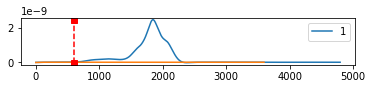

========================= 839


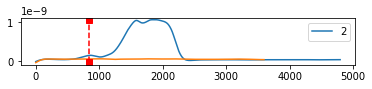

========================= 723


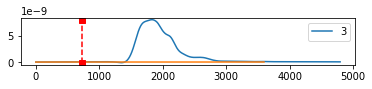

========================= 838


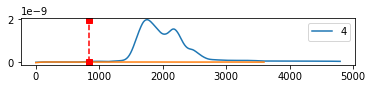

################################ TRIAL 2 ################################
========================= 748


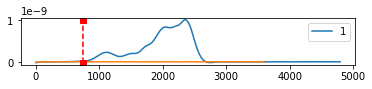

========================= 919


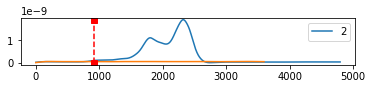

========================= 740


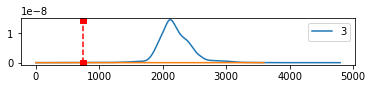

========================= 995


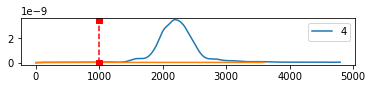

################################ TRIAL 3 ################################
========================= 968


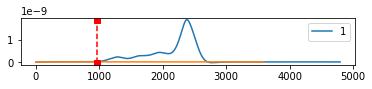

========================= 1127


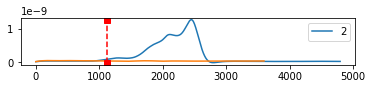

========================= 1169


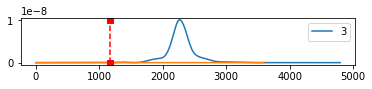

========================= 1268


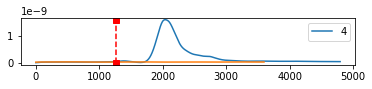

################################ TRIAL 4 ################################
========================= 739


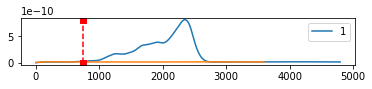

========================= 1083


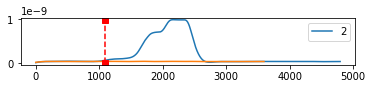

========================= 1240


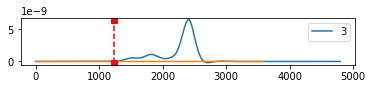

========================= 1531


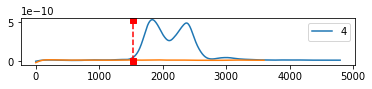

################################ TRIAL 5 ################################
========================= 1150


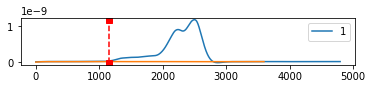

========================= 1169


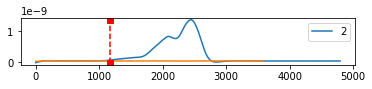

========================= 1383


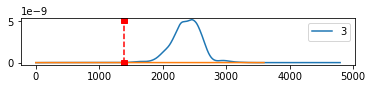

========================= 1615


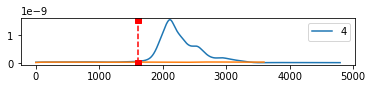

################################ TRIAL 6 ################################
========================= 1030


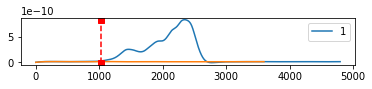

========================= 1151


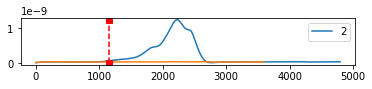

========================= 1275


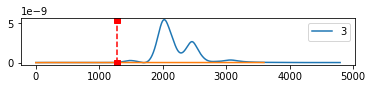

========================= 1345


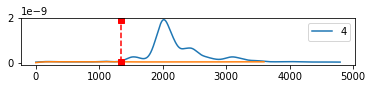

################################ TRIAL 7 ################################
========================= 865


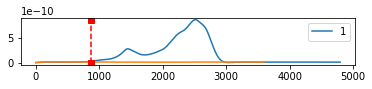

========================= 988


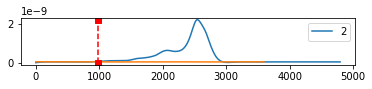

========================= 1245


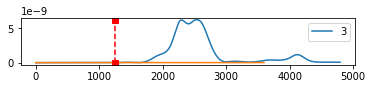

========================= 1427


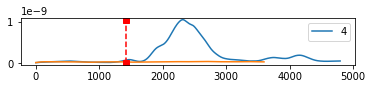

################################ TRIAL 8 ################################
========================= 968


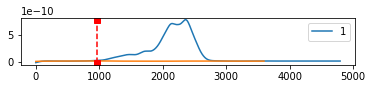

========================= 1174


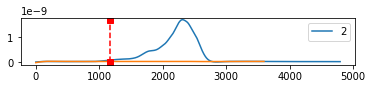

========================= 1151


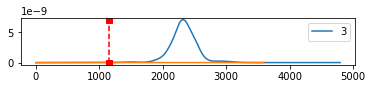

========================= 1179


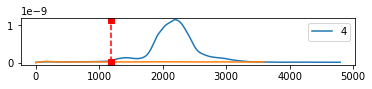

################################ TRIAL 9 ################################
========================= 793


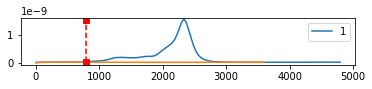

========================= 873


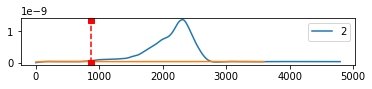

========================= 1179


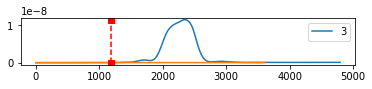

========================= 1222


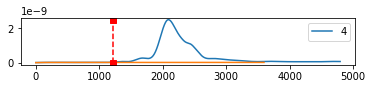

################################ TRIAL 10 ################################
========================= 1236


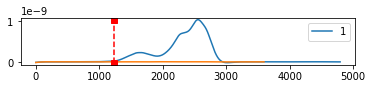

========================= 1240


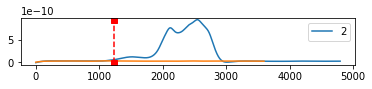

========================= 1357


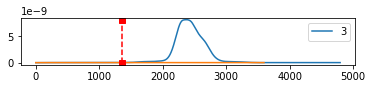

========================= 1362


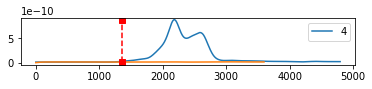

################################ TRIAL 11 ################################
========================= 1085


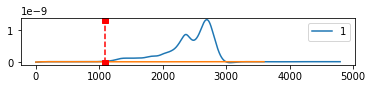

========================= 1208


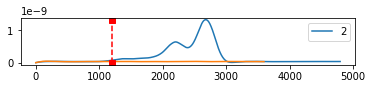

========================= 1310


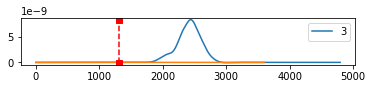

========================= 1303


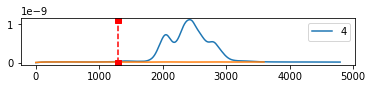

################################ TRIAL 12 ################################
========================= 1115


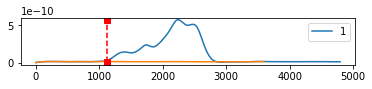

========================= 1151


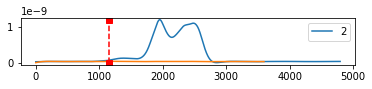

========================= 1184


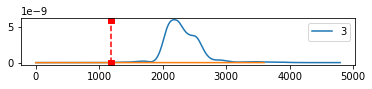

========================= 1489


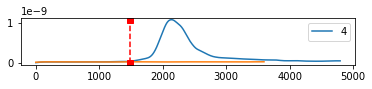

################################ TRIAL 13 ################################
========================= 904


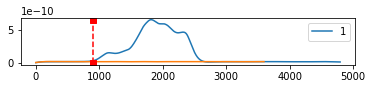

========================= 800


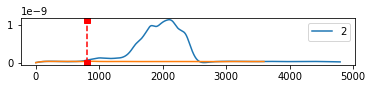

========================= 1128


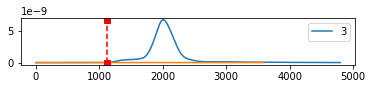

========================= 1234


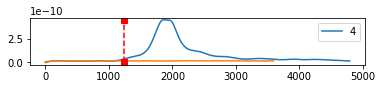

################################ TRIAL 14 ################################
========================= 1036


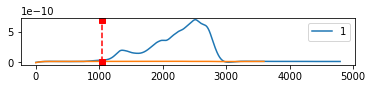

========================= 991


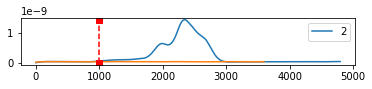

========================= 1354


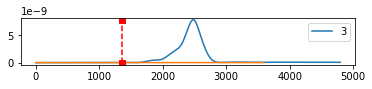

========================= 1399


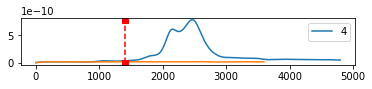

################################ TRIAL 15 ################################
========================= 1003


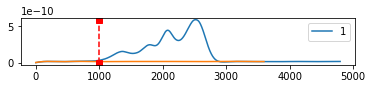

========================= 672


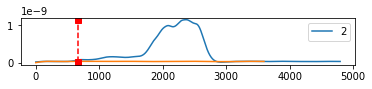

========================= 1352


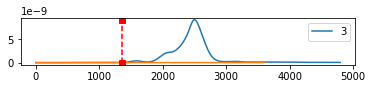

========================= 634


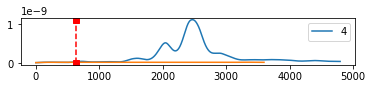

################################ TRIAL 16 ################################
========================= 1224


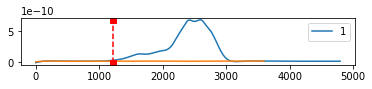

========================= 1060


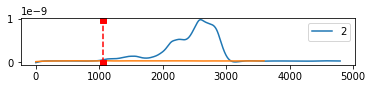

========================= 1365


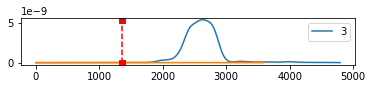

========================= 1844


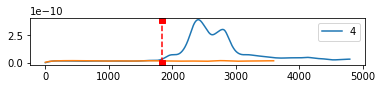

################################ TRIAL 17 ################################
========================= 1089


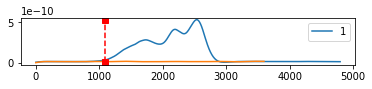

========================= 1088


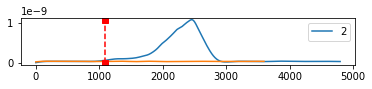

========================= 1215


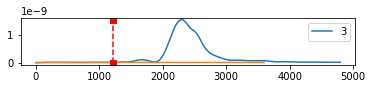

========================= 1218


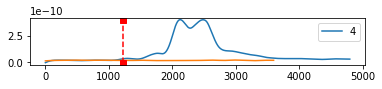

################################ TRIAL 18 ################################
========================= 893


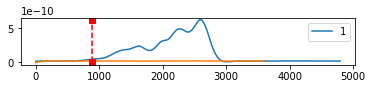

========================= 1020


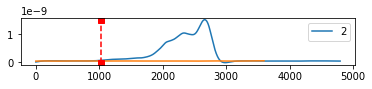

========================= 1287


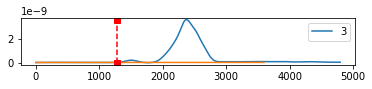

========================= 1926


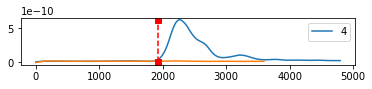

################################ TRIAL 19 ################################
========================= 1349


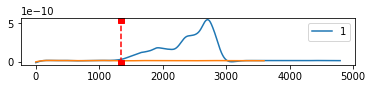

========================= 1446


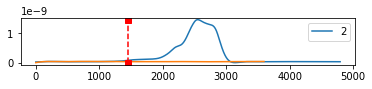

========================= 1639


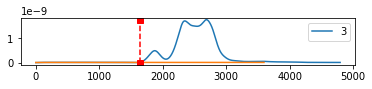

========================= 1732


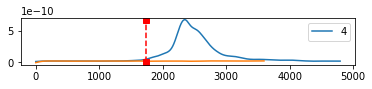

################################ TRIAL 20 ################################
========================= 936


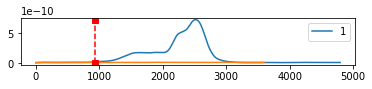

========================= 1109


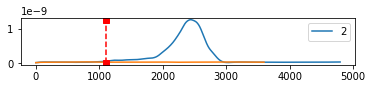

========================= 1485


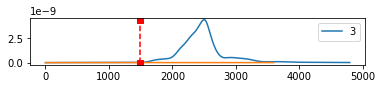

========================= 1545


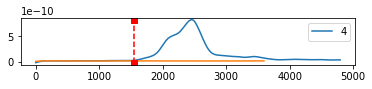

################################ TRIAL 21 ################################
========================= 1027


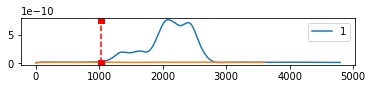

========================= 1045


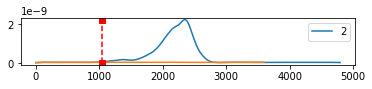

========================= 1337


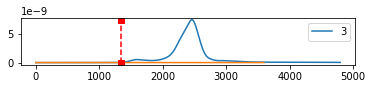

========================= 1343


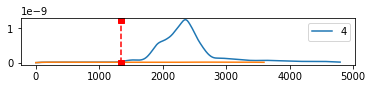

################################ TRIAL 22 ################################
========================= 1131


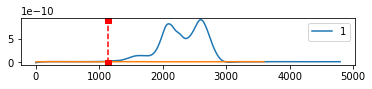

========================= 1166


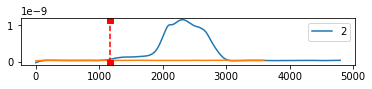

========================= 1449


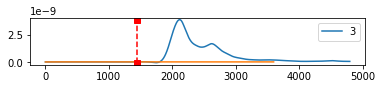

========================= 1482


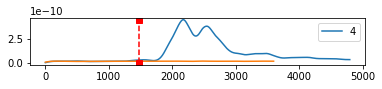

################################ TRIAL 23 ################################
========================= 1158


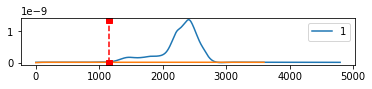

========================= 1186


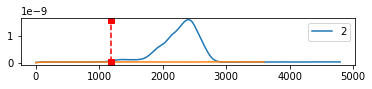

========================= 1567


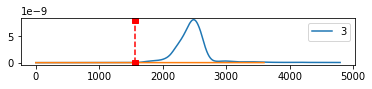

========================= 1669


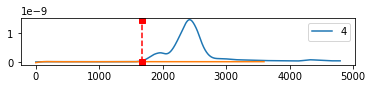

################################ TRIAL 24 ################################
========================= 1039


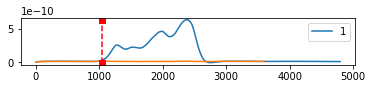

========================= 1137


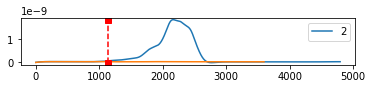

========================= 1084


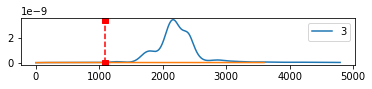

========================= 1096


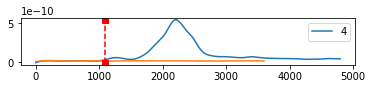

################################ TRIAL 25 ################################
========================= 1278


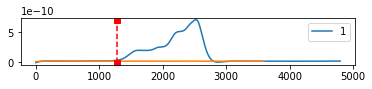

========================= 1352


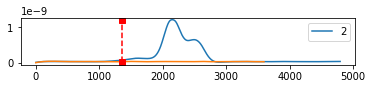

========================= 1491


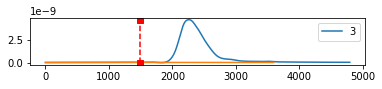

========================= 1877


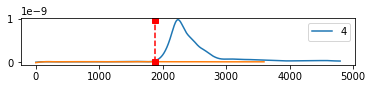

################################ TRIAL 26 ################################
========================= 1130


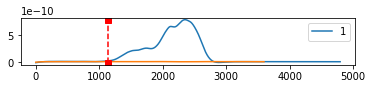

========================= 1164


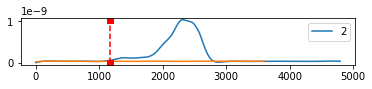

========================= 1428


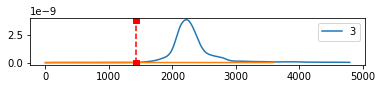

========================= 1787


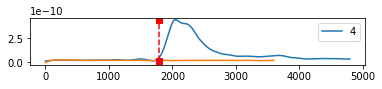

################################ TRIAL 27 ################################
========================= 1159


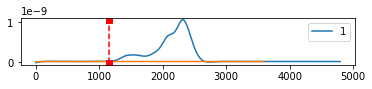

========================= 1266


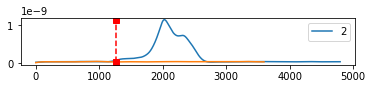

========================= 1702


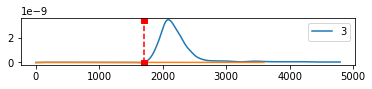

========================= 1717


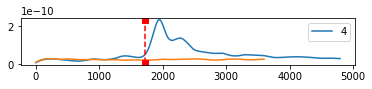

################################ TRIAL 28 ################################
========================= 1450


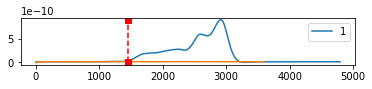

========================= 1430


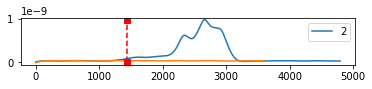

========================= 1596


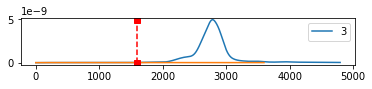

========================= 2094


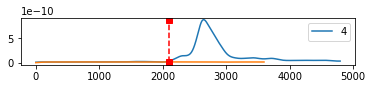

################################ TRIAL 29 ################################
========================= 1007


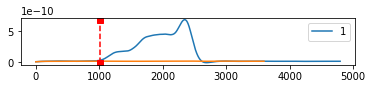

========================= 1069


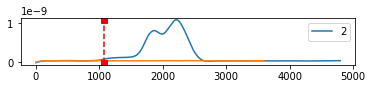

========================= 1278


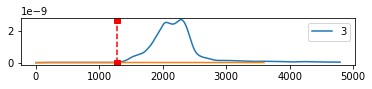

========================= 1674


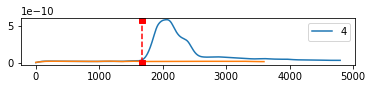

################################ TRIAL 30 ################################
========================= 1052


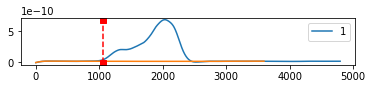

========================= 1022


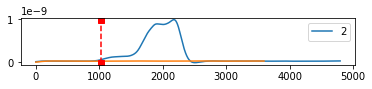

========================= 1337


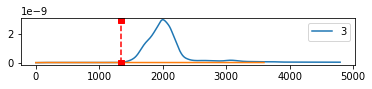

========================= 1344


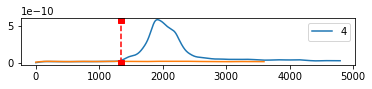

################################ TRIAL 31 ################################
========================= 1176


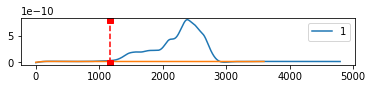

========================= 1152


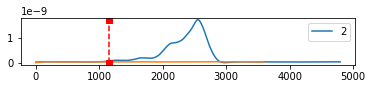

========================= 1497


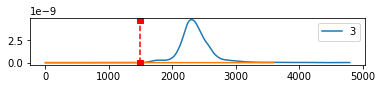

========================= 1709


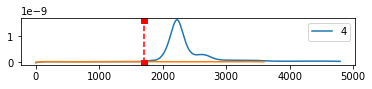

################################ TRIAL 32 ################################
========================= 913


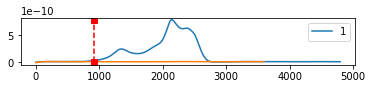

========================= 1084


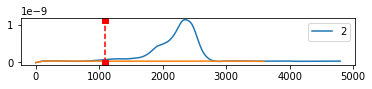

========================= 1257


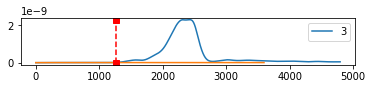

========================= 1503


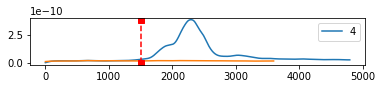

################################ TRIAL 33 ################################
========================= 1372


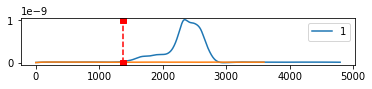

========================= 1510


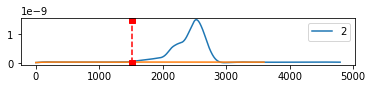

========================= 1674


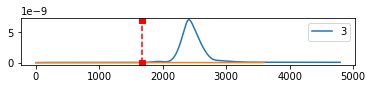

========================= 1914


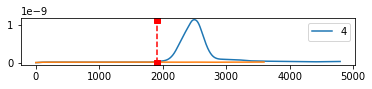

################################ TRIAL 34 ################################
========================= 775


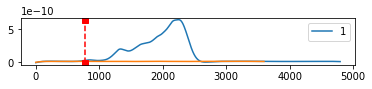

========================= 1016


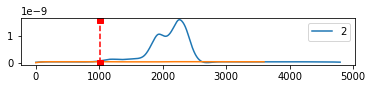

========================= 1386


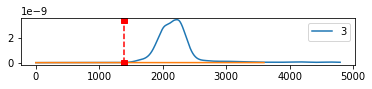

========================= 1548


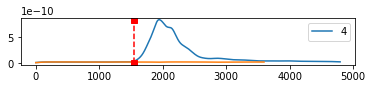

################################ TRIAL 35 ################################
========================= 1011


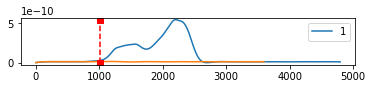

========================= 980


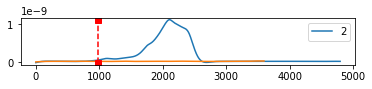

========================= 1228


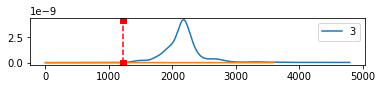

========================= 1394


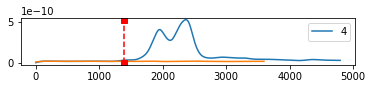

################################ TRIAL 36 ################################
========================= 1064


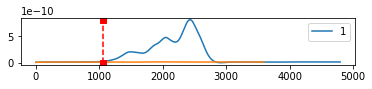

========================= 1092


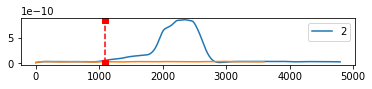

========================= 1551


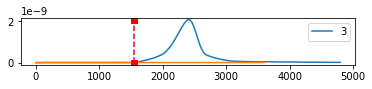

========================= 1654


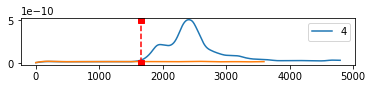

################################ TRIAL 37 ################################
========================= 1271


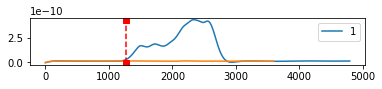

========================= 1437


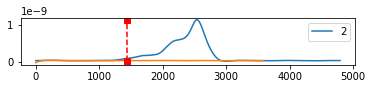

========================= 1439


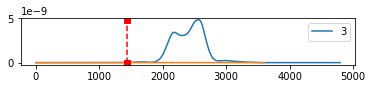

========================= 1913


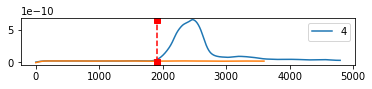

################################ TRIAL 38 ################################
========================= 1169


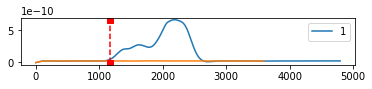

========================= 1274


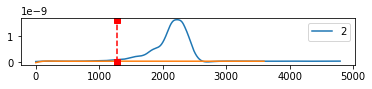

========================= 1384


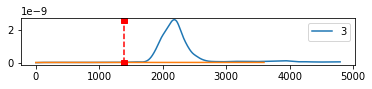

========================= 1708


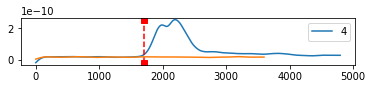

################################ TRIAL 39 ################################
========================= 1046


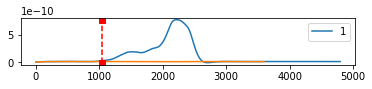

========================= 1012


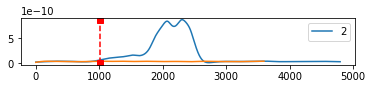

========================= 1361


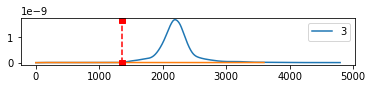

========================= 1740


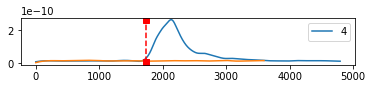

################################ TRIAL 40 ################################
========================= 1266


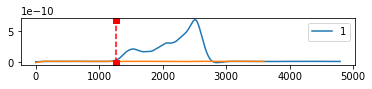

========================= 1234


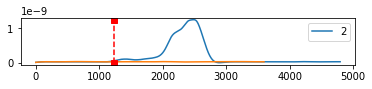

========================= 1568


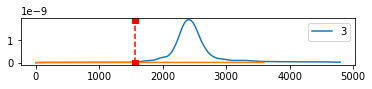

========================= 1958


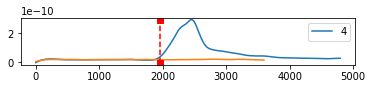

################################ TRIAL 41 ################################
========================= 755


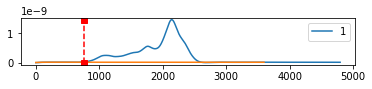

========================= 830


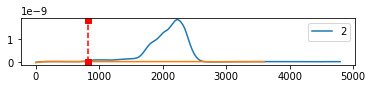

========================= 862


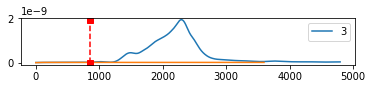

========================= 864


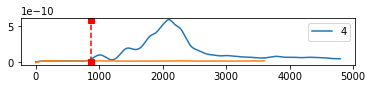

################################ TRIAL 42 ################################
========================= 1072


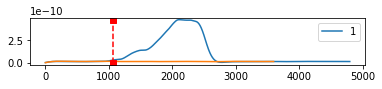

========================= 1160


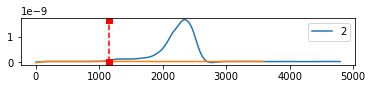

========================= 1479


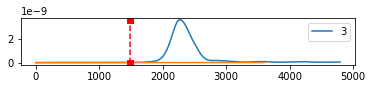

========================= 1785


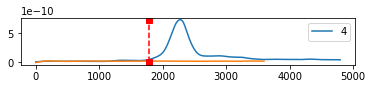

################################ TRIAL 43 ################################
========================= 965


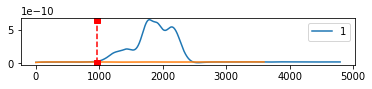

========================= 1041


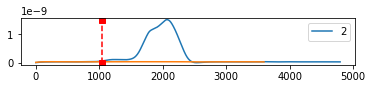

========================= 1218


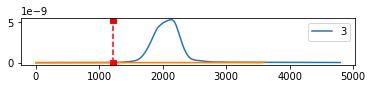

========================= 1252


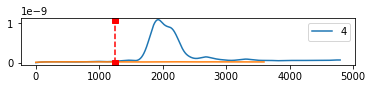

################################ TRIAL 44 ################################
========================= 1870


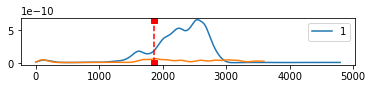

========================= 1300


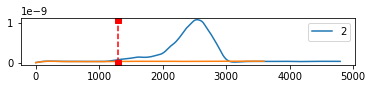

========================= 1656


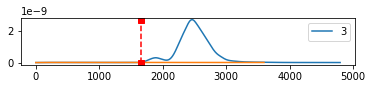

========================= 1735


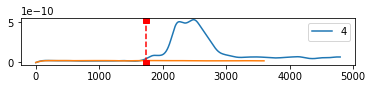

################################ TRIAL 45 ################################
========================= 1120


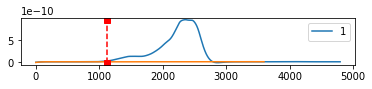

========================= 1256


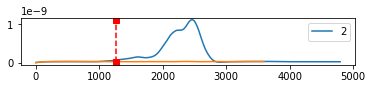

========================= 1678


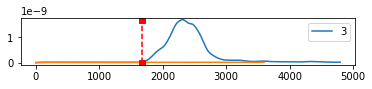

========================= 1746


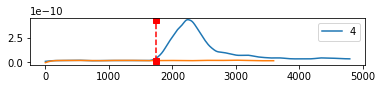

################################ TRIAL 46 ################################
========================= 1327


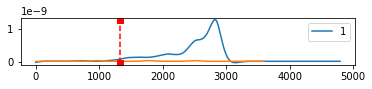

========================= 1322


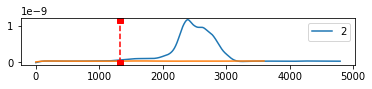

========================= 1897


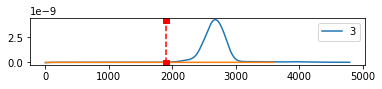

========================= 1974


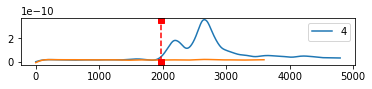

################################ TRIAL 47 ################################
========================= 1425


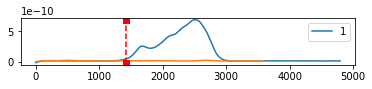

========================= 1338


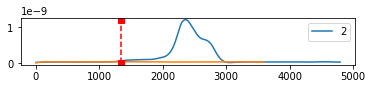

========================= 1735


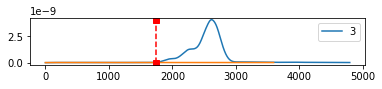

========================= 1935


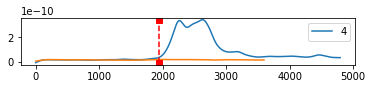

################################ TRIAL 48 ################################
========================= 955


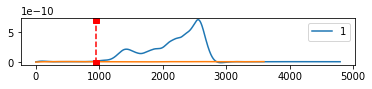

========================= 1123


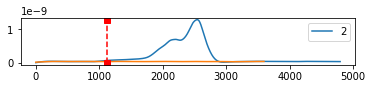

========================= 1672


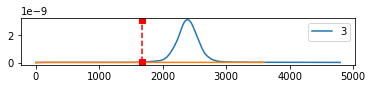

========================= 1935


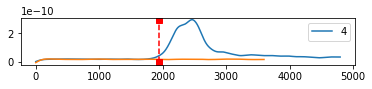

################################ TRIAL 49 ################################
========================= 1686


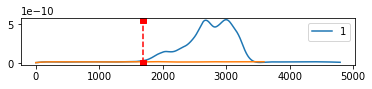

========================= 1800


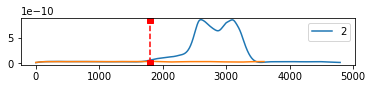

========================= 2128


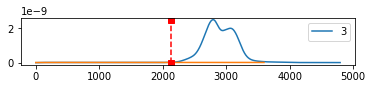

========================= 2261


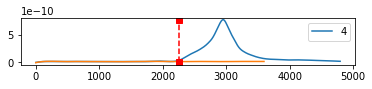

################################ TRIAL 50 ################################
========================= 996


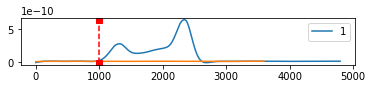

========================= 1120


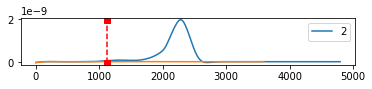

========================= 1588


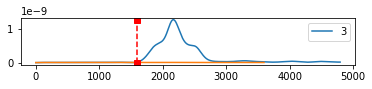

========================= 1644


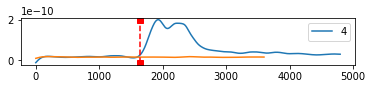

################################ TRIAL 51 ################################
========================= 1207


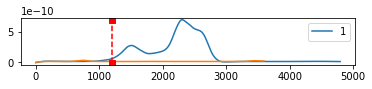

========================= 1083


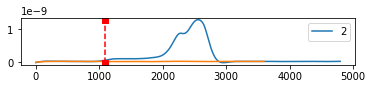

========================= 1865


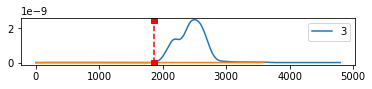

========================= 1878


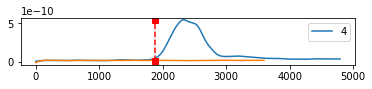

################################ TRIAL 52 ################################
========================= 1236


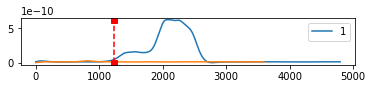

========================= 1097


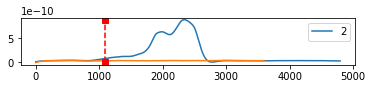

========================= 1699


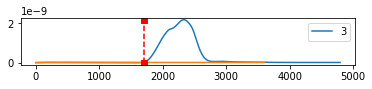

========================= 1761


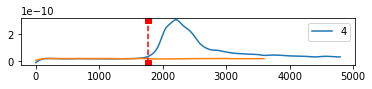

################################ TRIAL 53 ################################
========================= 905


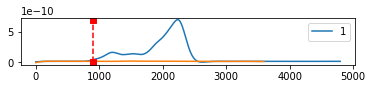

========================= 1003


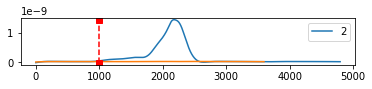

========================= 1310


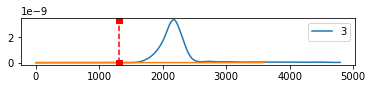

========================= 1607


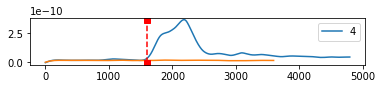

################################ TRIAL 54 ################################
========================= 853


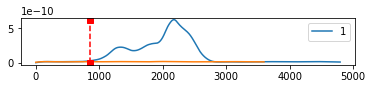

========================= 887


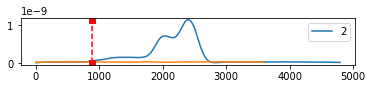

========================= 1309


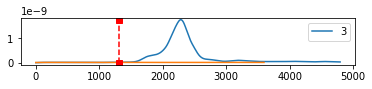

========================= 1599


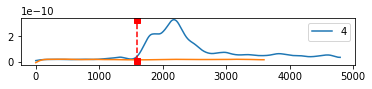

################################ TRIAL 55 ################################
========================= 990


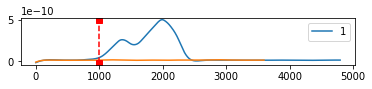

========================= 898


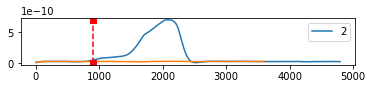

========================= 1506


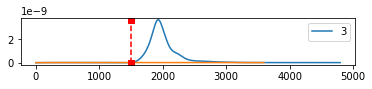

========================= 1542


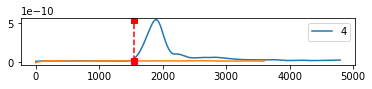

################################ TRIAL 56 ################################
========================= 1082


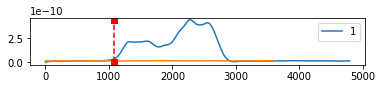

========================= 1068


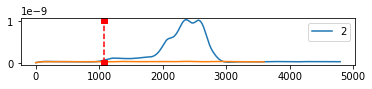

========================= 1578


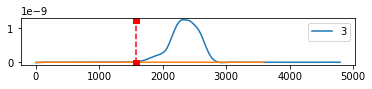

========================= 1714


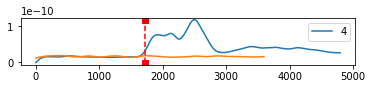

################################ TRIAL 57 ################################
========================= 1340


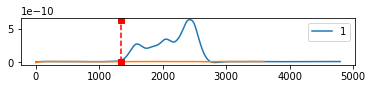

========================= 1386


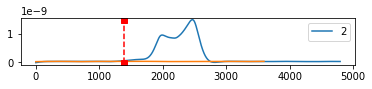

========================= 1636


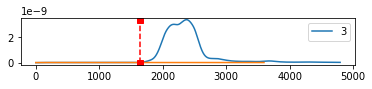

========================= 1692


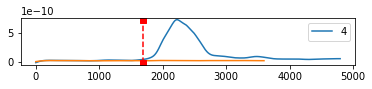

################################ TRIAL 58 ################################
========================= 1351


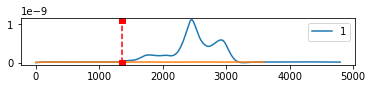

========================= 1158


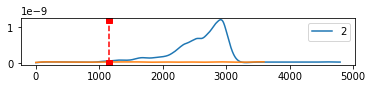

========================= 1896


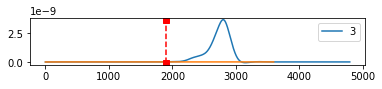

========================= 1920


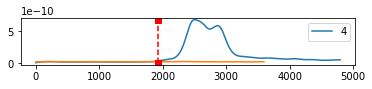

################################ TRIAL 59 ################################
========================= 1028


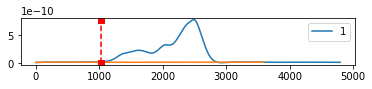

========================= 971


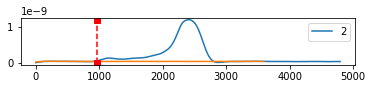

========================= 1539


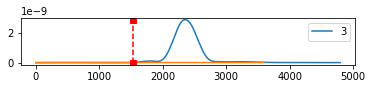

========================= 1610


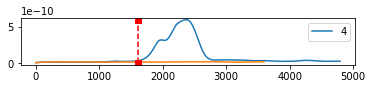

################################ TRIAL 60 ################################
========================= 929


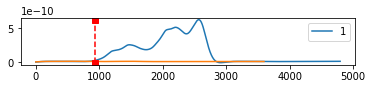

========================= 1051


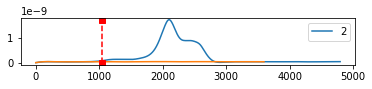

========================= 1400


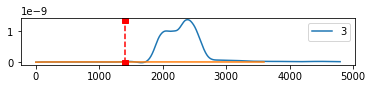

========================= 1784


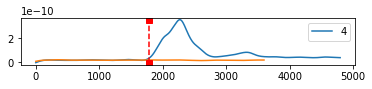

################################ TRIAL 61 ################################
========================= 1008


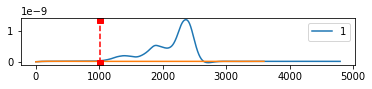

========================= 1051


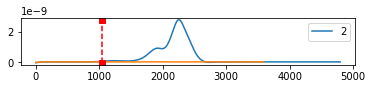

========================= 1196


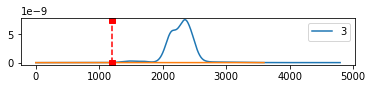

========================= 1651


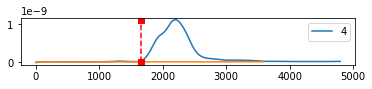

################################ TRIAL 62 ################################
========================= 860


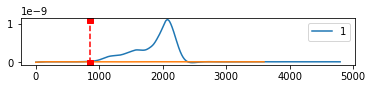

========================= 868


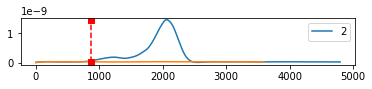

========================= 1157


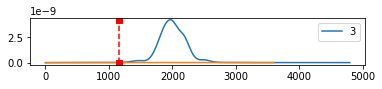

========================= 960


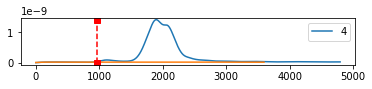

################################ TRIAL 63 ################################
========================= 925


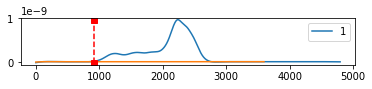

========================= 1063


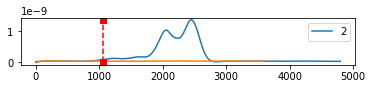

========================= 1051


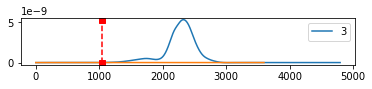

========================= 979


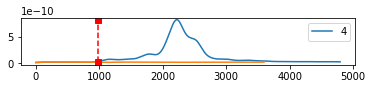

################################ TRIAL 64 ################################
========================= 946


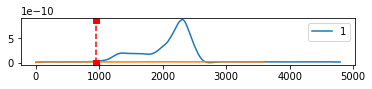

========================= 1036


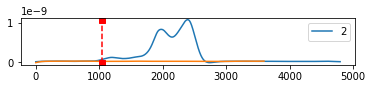

========================= 1259


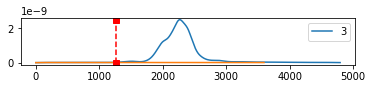

========================= 1802


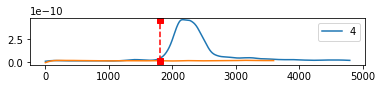

################################ TRIAL 65 ################################
========================= 889


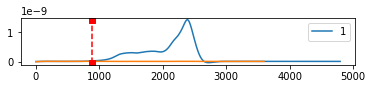

========================= 975


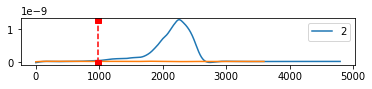

========================= 1264


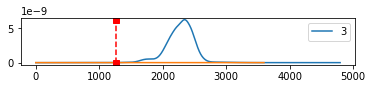

========================= 1480


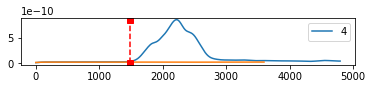

################################ TRIAL 66 ################################
========================= 910


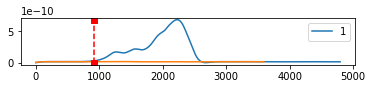

========================= 904


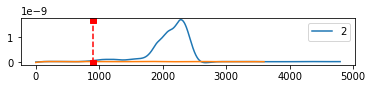

========================= 1278


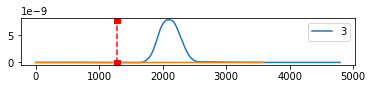

========================= 1627


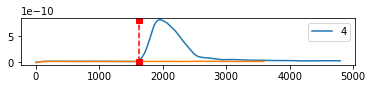

################################ TRIAL 67 ################################
========================= 1364


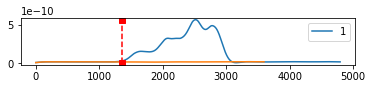

========================= 1419


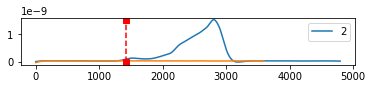

========================= 1545


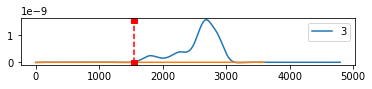

========================= 1560


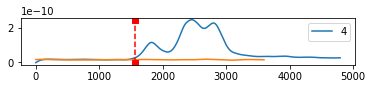

################################ TRIAL 68 ################################
========================= 875


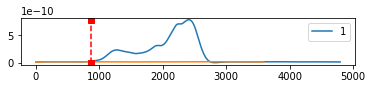

========================= 1044


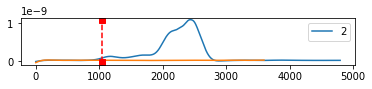

========================= 1179


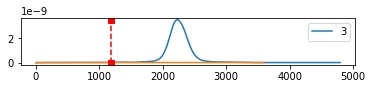

========================= 1753


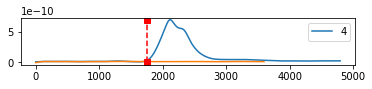

################################ TRIAL 69 ################################
========================= 865


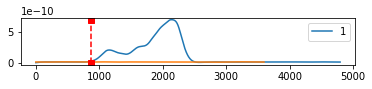

========================= 938


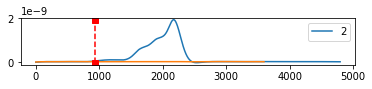

========================= 1345


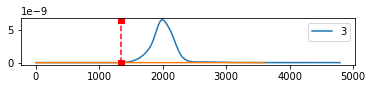

========================= 1438


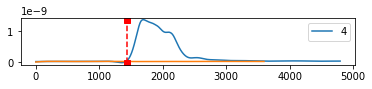

################################ TRIAL 70 ################################
========================= 1235


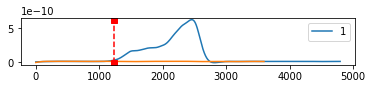

========================= 1262


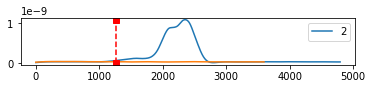

========================= 1485


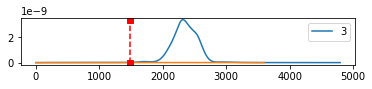

========================= 1856


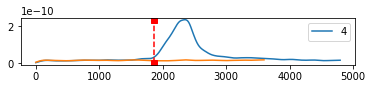

################################ TRIAL 71 ################################
========================= 1063


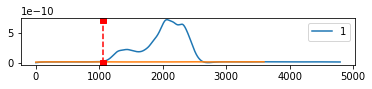

========================= 1064


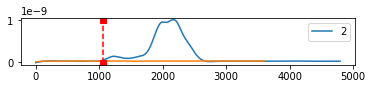

========================= 1686


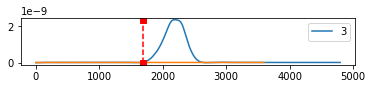

========================= 1716


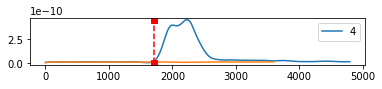

################################ TRIAL 72 ################################
========================= 1196


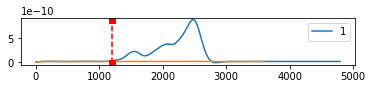

========================= 1316


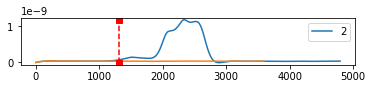

========================= 1685


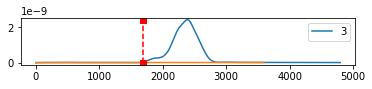

========================= 1734


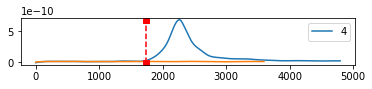

################################ TRIAL 73 ################################
========================= 993


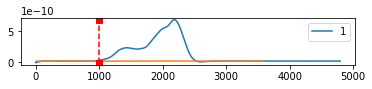

========================= 1209


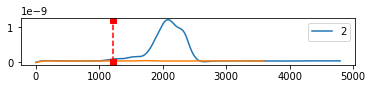

========================= 1294


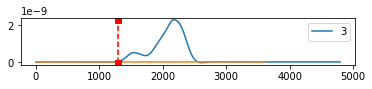

========================= 1316


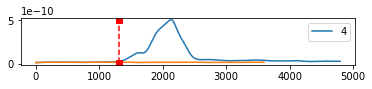

################################ TRIAL 74 ################################
========================= 1046


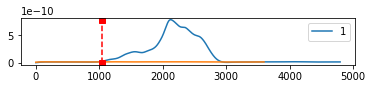

========================= 1190


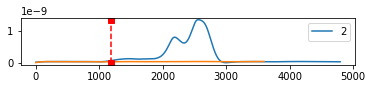

========================= 1604


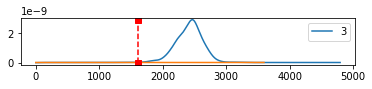

========================= 1331


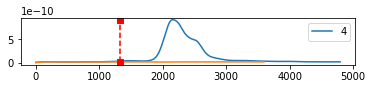

################################ TRIAL 75 ################################
========================= 1099


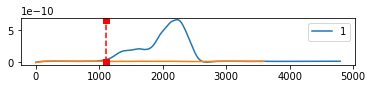

========================= 1187


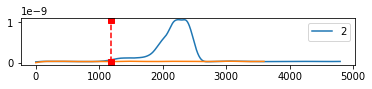

========================= 1510


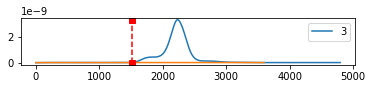

========================= 1565


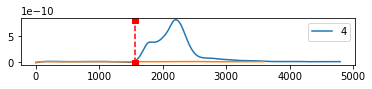

################################ TRIAL 76 ################################
========================= 1065


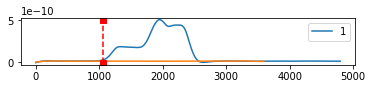

========================= 1165


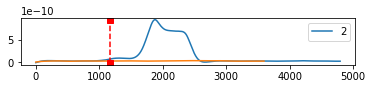

========================= 1534


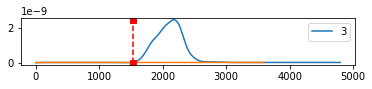

========================= 1631


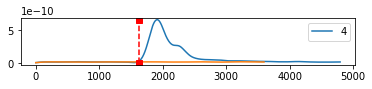

################################ TRIAL 77 ################################
========================= 1095


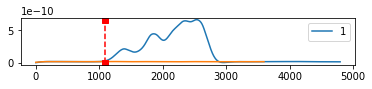

========================= 1228


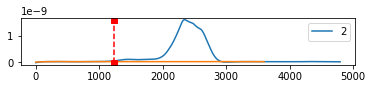

========================= 1559


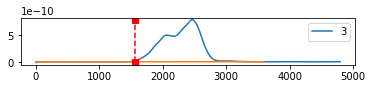

========================= 1937


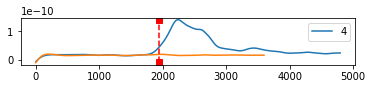

################################ TRIAL 78 ################################
========================= 1065


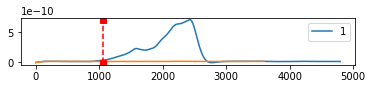

========================= 1161


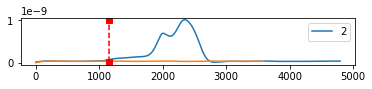

========================= 1588


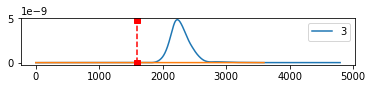

========================= 1706


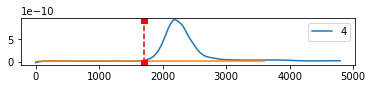

################################ TRIAL 79 ################################
========================= 1088


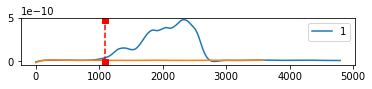

========================= 1081


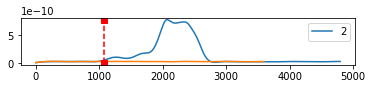

========================= 1358


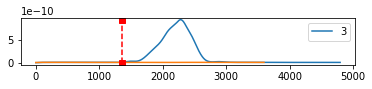

========================= 1633


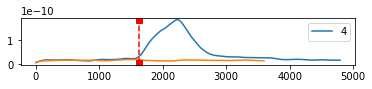

################################ TRIAL 80 ################################
========================= 847


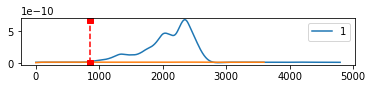

========================= 936


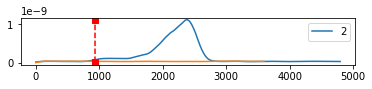

========================= 1488


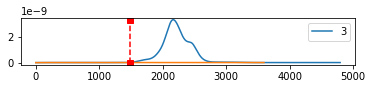

========================= 1436


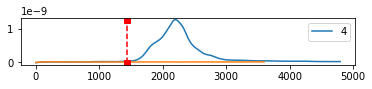

################################ TRIAL 81 ################################
========================= 1079


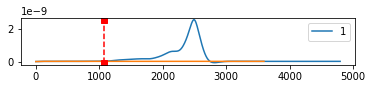

========================= 937


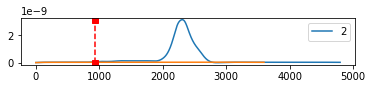

========================= 1774


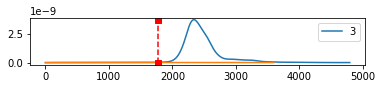

========================= 1822


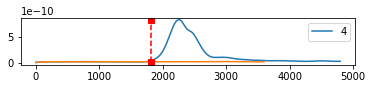

################################ TRIAL 82 ################################
========================= 1845


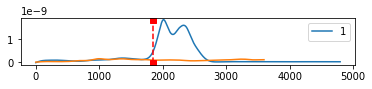

========================= 1611


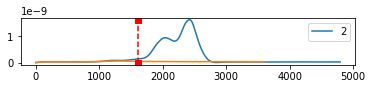

========================= 2059


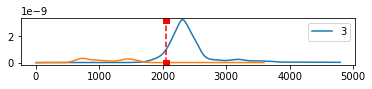

========================= None


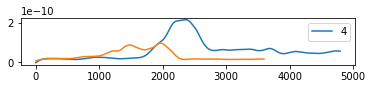

################################ TRIAL 83 ################################
========================= 1201


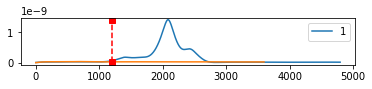

========================= 1286


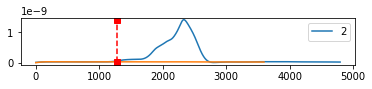

========================= 1839


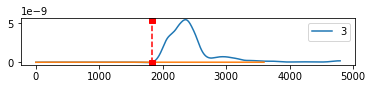

========================= 1680


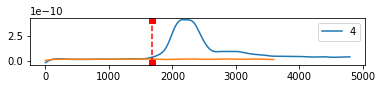

################################ TRIAL 84 ################################
========================= 1115


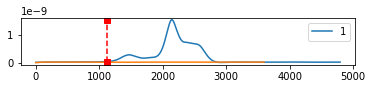

========================= 1193


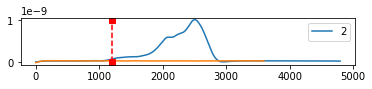

========================= 1690


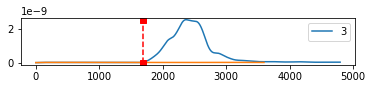

========================= 1760


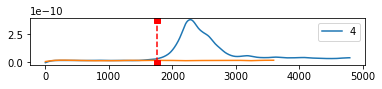

################################ TRIAL 85 ################################
========================= 912


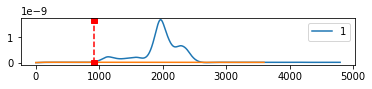

========================= 1128


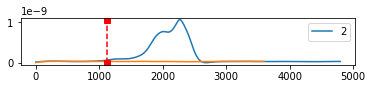

========================= 1480


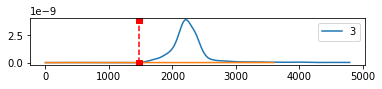

========================= 1571


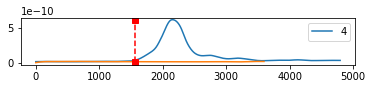

################################ TRIAL 86 ################################
========================= 1172


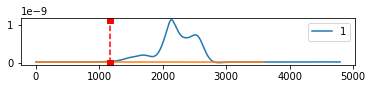

========================= 1193


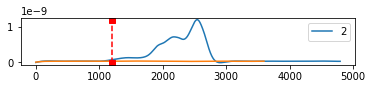

========================= 1714


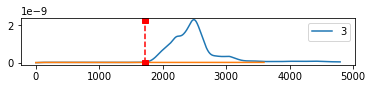

========================= 1794


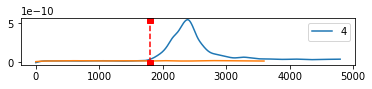

################################ TRIAL 87 ################################
========================= 1027


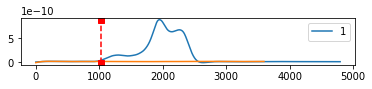

========================= 1102


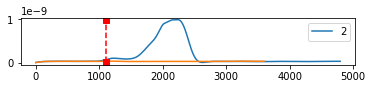

========================= 1379


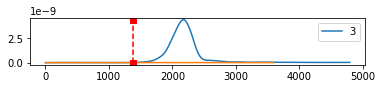

========================= 1543


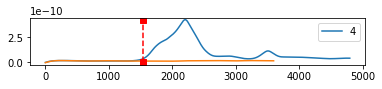

################################ TRIAL 88 ################################
========================= 1211


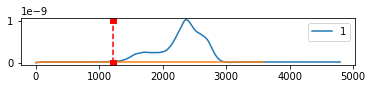

========================= 1412


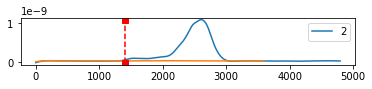

========================= 1559


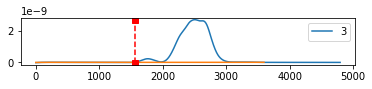

========================= 2037


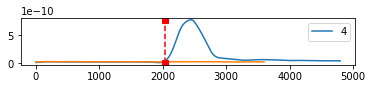

################################ TRIAL 89 ################################
========================= 956


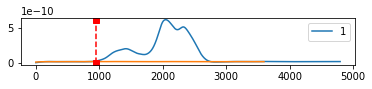

========================= 1162


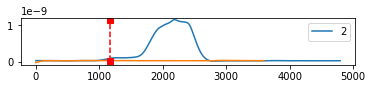

========================= 1518


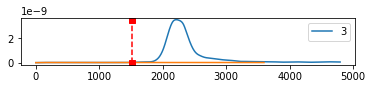

========================= 1757


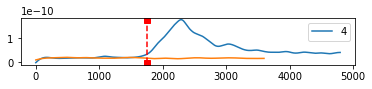

################################ TRIAL 90 ################################
========================= 1062


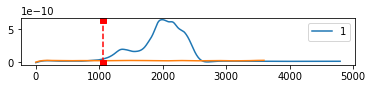

========================= 1154


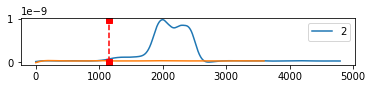

========================= 1676


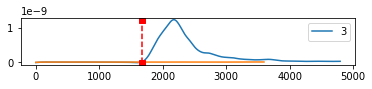

========================= 1808


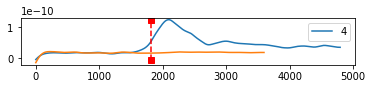

################################ TRIAL 91 ################################
========================= 1312


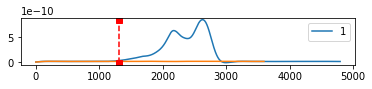

========================= 1242


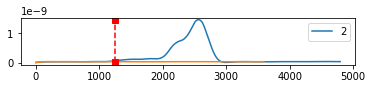

========================= 1902


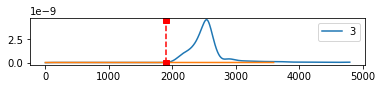

========================= 1914


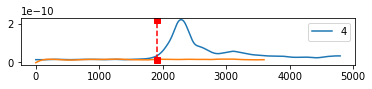

################################ TRIAL 92 ################################
========================= 950


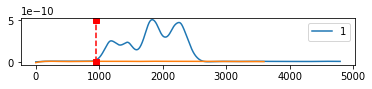

========================= 954


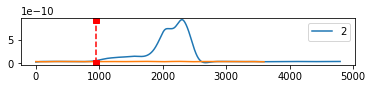

========================= 1600


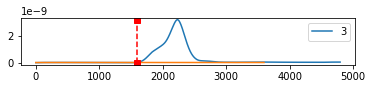

========================= 1626


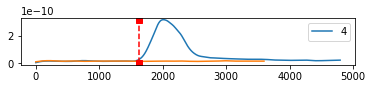

################################ TRIAL 93 ################################
========================= 1495


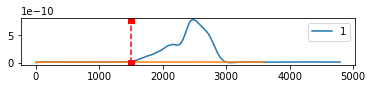

========================= 1439


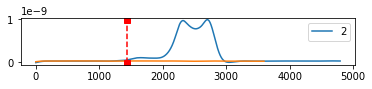

========================= 1811


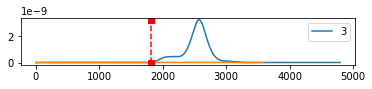

========================= 1924


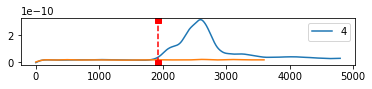

################################ TRIAL 94 ################################
========================= 1438


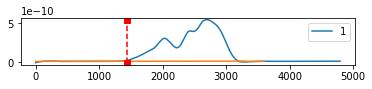

========================= 1559


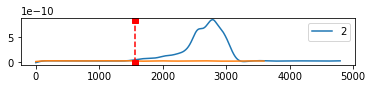

========================= 2051


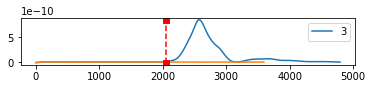

========================= 1923


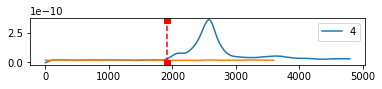

################################ TRIAL 95 ################################
========================= 941


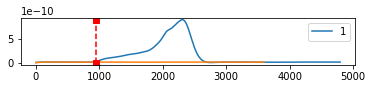

========================= 1318


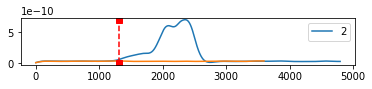

========================= 1549


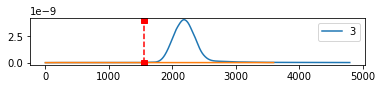

========================= 1862


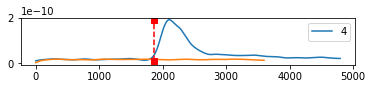

################################ TRIAL 96 ################################
========================= 1216


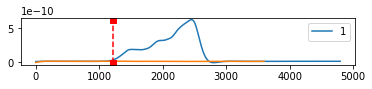

========================= 1159


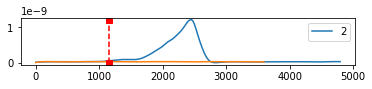

========================= 1609


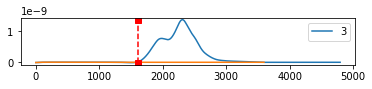

========================= 1700


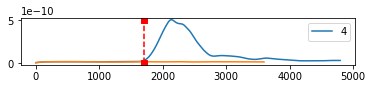

################################ TRIAL 97 ################################
========================= 1001


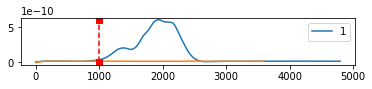

========================= 1071


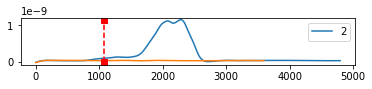

========================= 1650


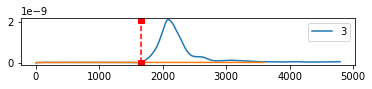

========================= 1281


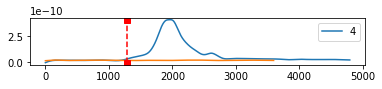

################################ TRIAL 98 ################################
========================= 1021


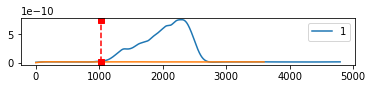

========================= 1033


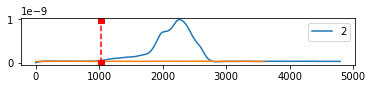

========================= 1463


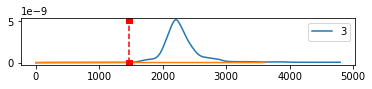

========================= 1671


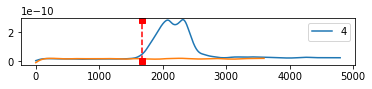

################################ TRIAL 99 ################################
========================= 821


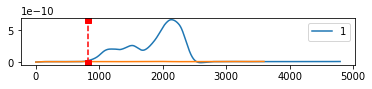

========================= 1025


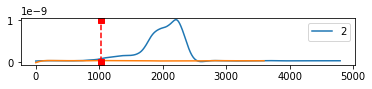

========================= 1476


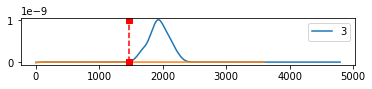

========================= 1504


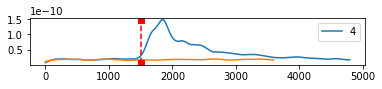

################################ TRIAL 100 ################################
========================= 951


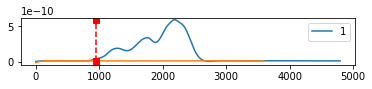

========================= 1194


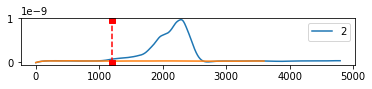

========================= 1513


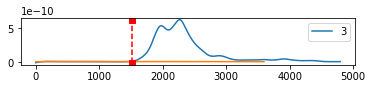

========================= 1680


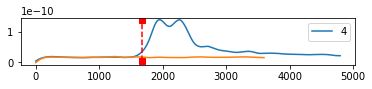

################################ TRIAL 1 ################################
========================= 805


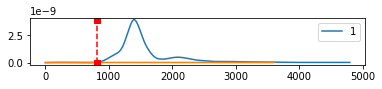

========================= 860


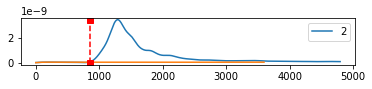

========================= 448


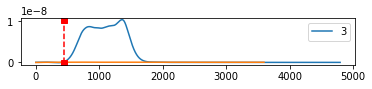

========================= 411


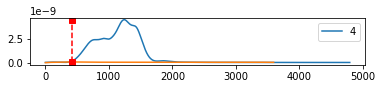

################################ TRIAL 2 ################################
========================= 1038


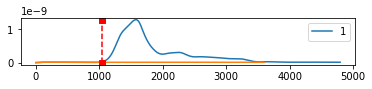

========================= 1129


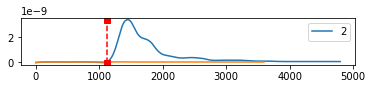

========================= 328


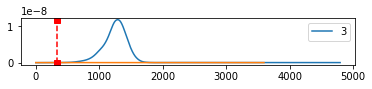

========================= 375


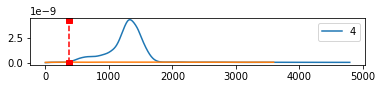

################################ TRIAL 3 ################################
========================= 868


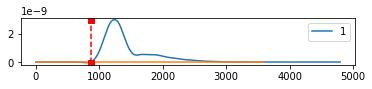

========================= 842


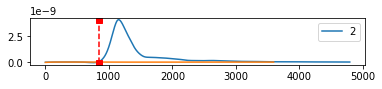

========================= 376


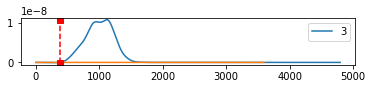

========================= 316


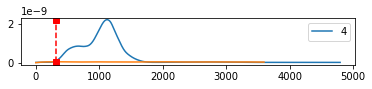

################################ TRIAL 4 ################################
========================= 1291


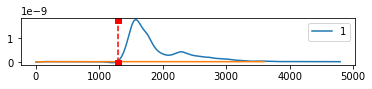

========================= 1242


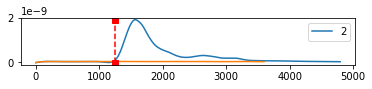

========================= 607


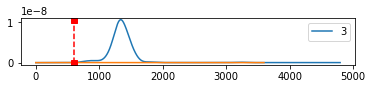

========================= 645


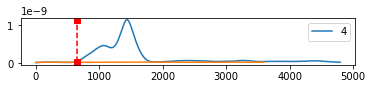

################################ TRIAL 5 ################################
========================= 1264


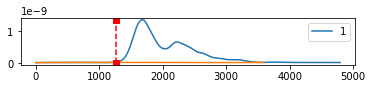

========================= 1264


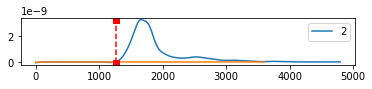

========================= 506


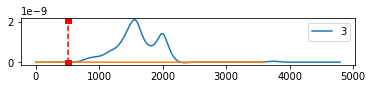

========================= 906


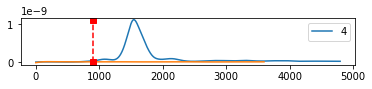

################################ TRIAL 6 ################################
========================= 1324


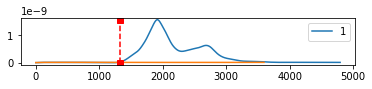

========================= 1368


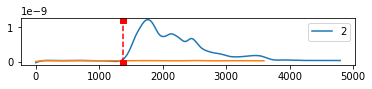

========================= 391


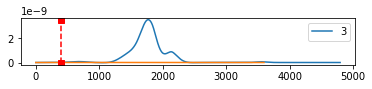

========================= 520


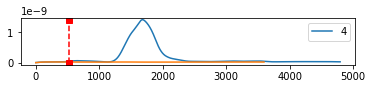

################################ TRIAL 7 ################################
========================= 1417


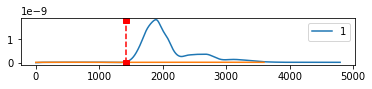

========================= 1397


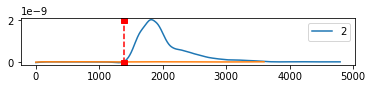

========================= 436


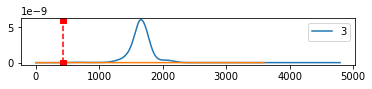

========================= 864


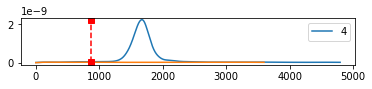

################################ TRIAL 8 ################################
========================= 1049


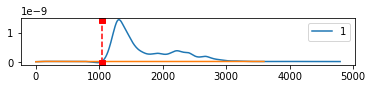

========================= 1017


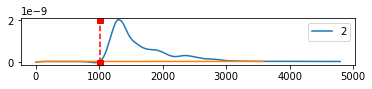

========================= 338


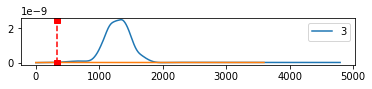

========================= 429


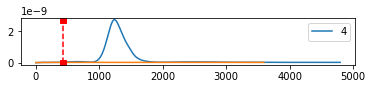

################################ TRIAL 9 ################################
========================= 1124


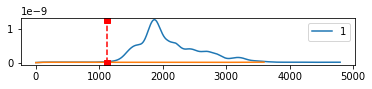

========================= 1052


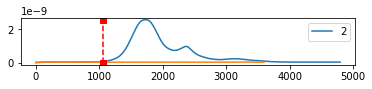

========================= 527


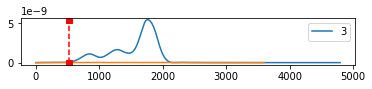

========================= 621


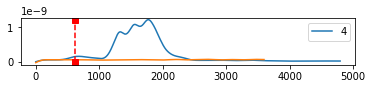

################################ TRIAL 10 ################################
========================= 1066


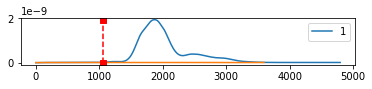

========================= 1255


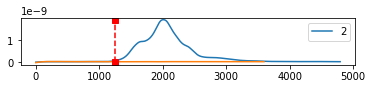

========================= 799


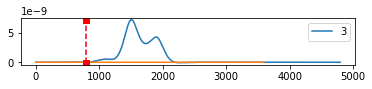

========================= 749


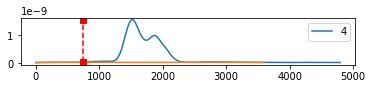

################################ TRIAL 11 ################################
========================= 1553


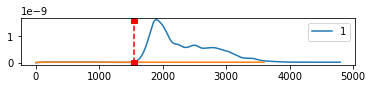

========================= 1527


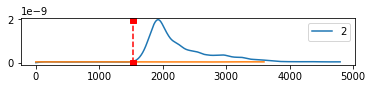

========================= 1193


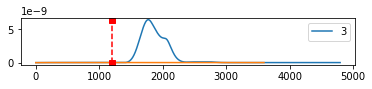

========================= 1137


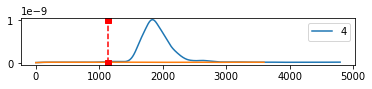

################################ TRIAL 12 ################################
========================= 1361


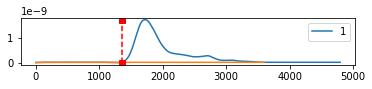

========================= 1292


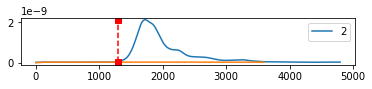

========================= 905


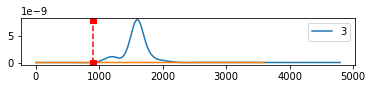

========================= 945


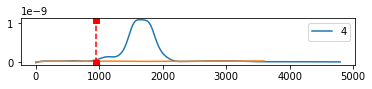

################################ TRIAL 13 ################################
========================= 1403


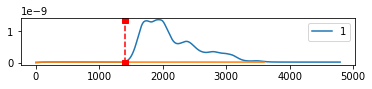

========================= 1380


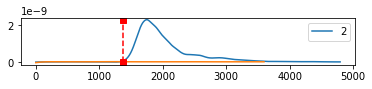

========================= 894


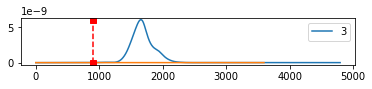

========================= 908


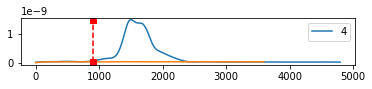

################################ TRIAL 14 ################################
========================= 1160


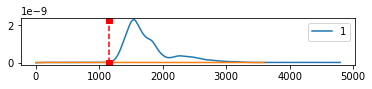

========================= 1132


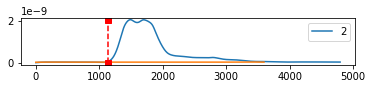

========================= 725


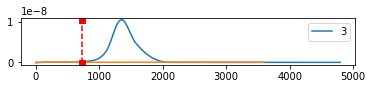

========================= 766


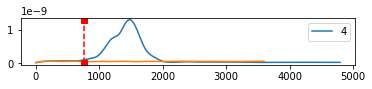

################################ TRIAL 15 ################################
========================= 1171


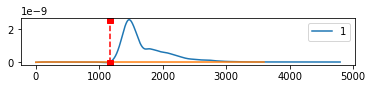

========================= 1091


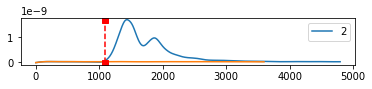

========================= 342


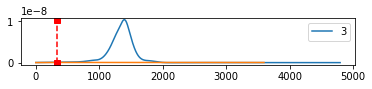

========================= 542


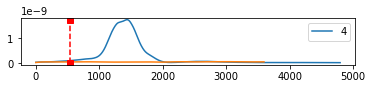

################################ TRIAL 16 ################################
========================= 1376


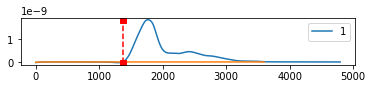

========================= 1376


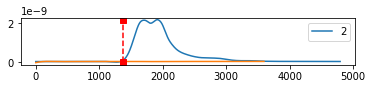

========================= 558


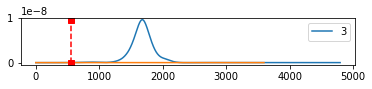

========================= 688


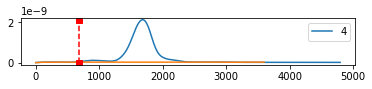

################################ TRIAL 17 ################################
========================= 1177


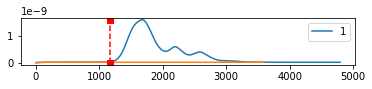

========================= 974


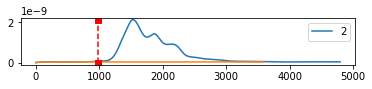

========================= 341


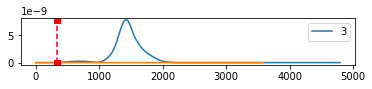

========================= 369


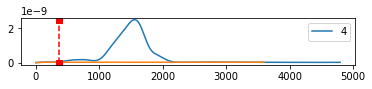

################################ TRIAL 18 ################################
========================= 1538


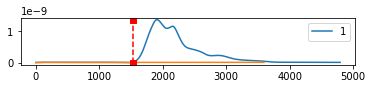

========================= 1491


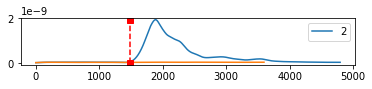

========================= 905


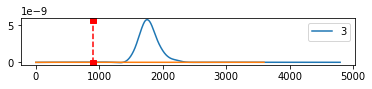

========================= 544


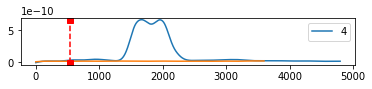

################################ TRIAL 19 ################################
========================= 1474


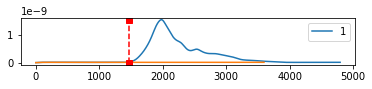

========================= 1465


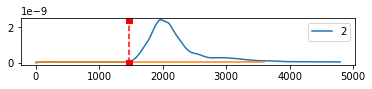

========================= 783


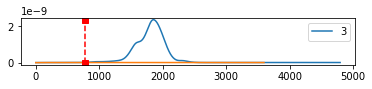

========================= 865


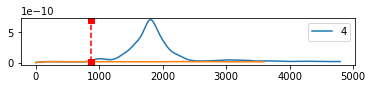

################################ TRIAL 20 ################################
========================= 1402


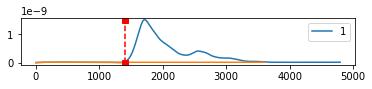

========================= 1316


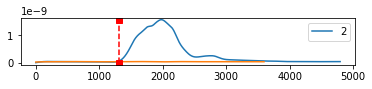

========================= 979


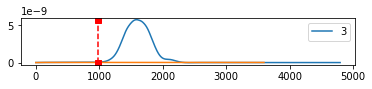

========================= 967


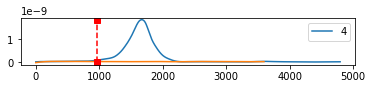

################################ TRIAL 21 ################################
========================= 1032


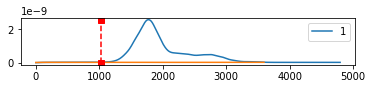

========================= 993


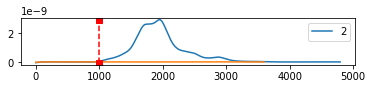

========================= 651


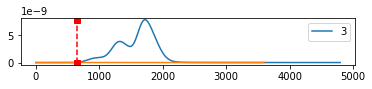

========================= 516


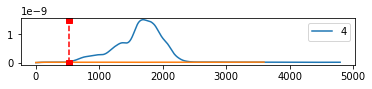

################################ TRIAL 22 ################################
========================= 1448


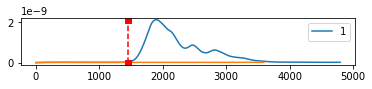

========================= 1405


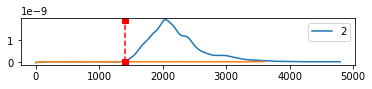

========================= 1264


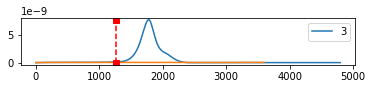

========================= 1282


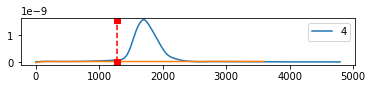

################################ TRIAL 23 ################################
========================= 1370


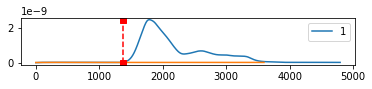

========================= 1268


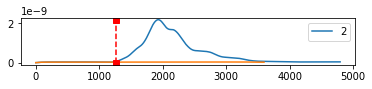

========================= 1307


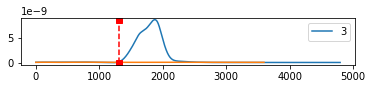

========================= 1342


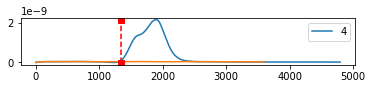

################################ TRIAL 24 ################################
========================= 1285


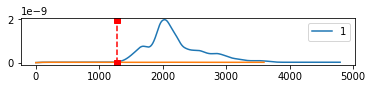

========================= 1209


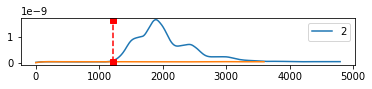

========================= 1184


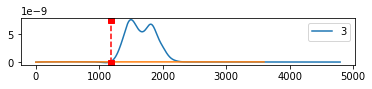

========================= 1248


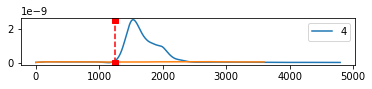

################################ TRIAL 25 ################################
========================= 1538


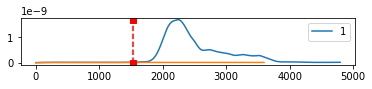

========================= 1717


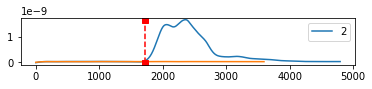

========================= 1195


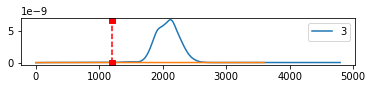

========================= 1660


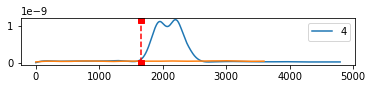

################################ TRIAL 26 ################################
========================= 1466


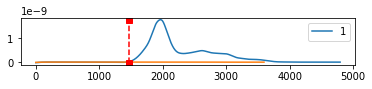

========================= 1457


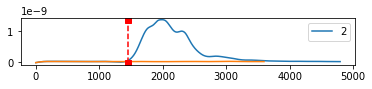

========================= 1339


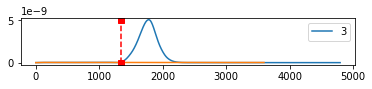

========================= 1411


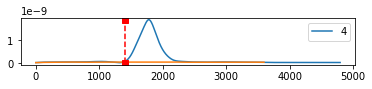

################################ TRIAL 27 ################################
========================= 1117


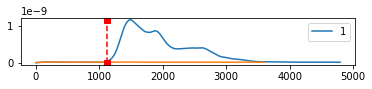

========================= 1099


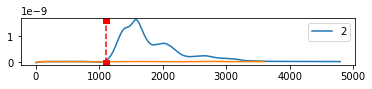

========================= 343


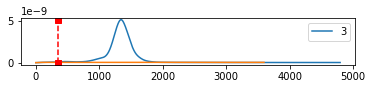

========================= 328


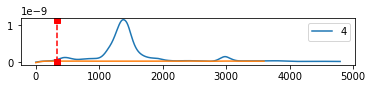

################################ TRIAL 28 ################################
========================= 1255


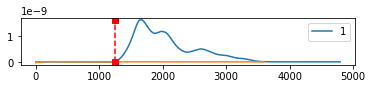

========================= 1227


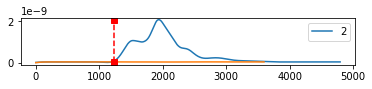

========================= 379


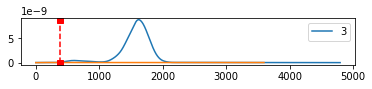

========================= 462


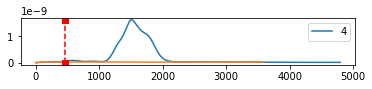

################################ TRIAL 29 ################################
========================= 1446


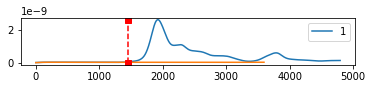

========================= 1516


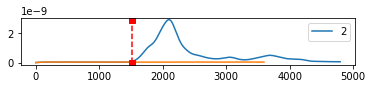

========================= 1084


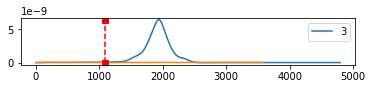

========================= 1416


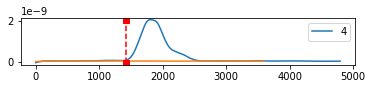

################################ TRIAL 30 ################################
========================= 1442


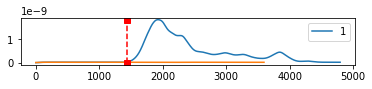

========================= 1441


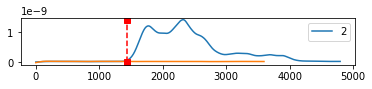

========================= 1325


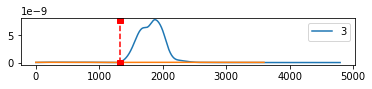

========================= 1240


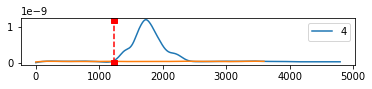

################################ TRIAL 31 ################################
========================= 1170


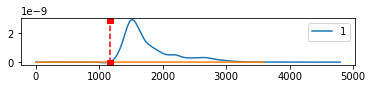

========================= 1119


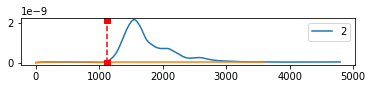

========================= 1034


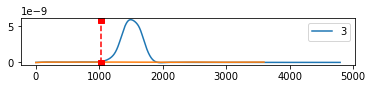

========================= 984


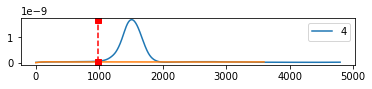

################################ TRIAL 32 ################################
========================= 1378


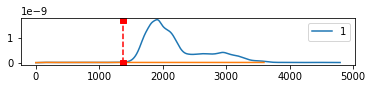

========================= 1353


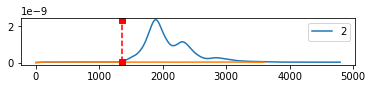

========================= 902


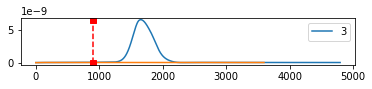

========================= 1341


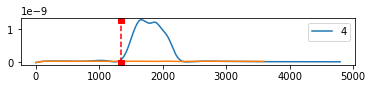

################################ TRIAL 33 ################################
========================= 1811


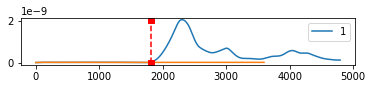

========================= 1844


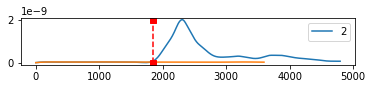

========================= 1432


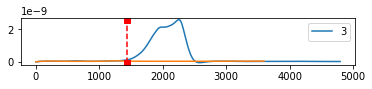

========================= 1319


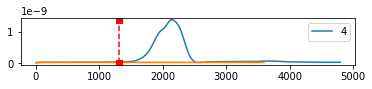

################################ TRIAL 34 ################################
========================= 1288


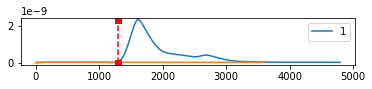

========================= 1260


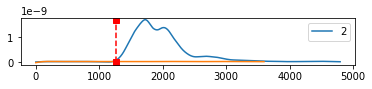

========================= 775


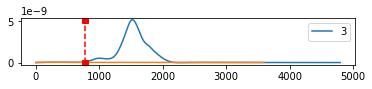

========================= 808


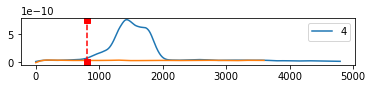

################################ TRIAL 35 ################################
========================= 1530


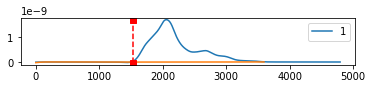

========================= 1532


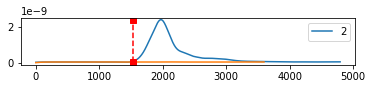

========================= 896


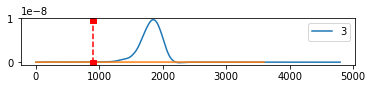

========================= 1309


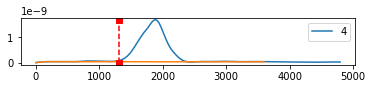

################################ TRIAL 36 ################################
========================= 955


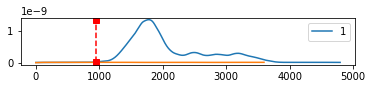

========================= 999


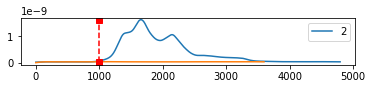

========================= 420


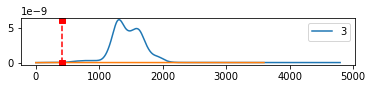

========================= 439


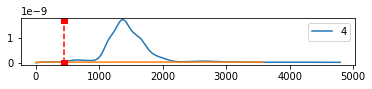

################################ TRIAL 37 ################################
========================= 1536


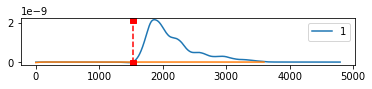

========================= 1509


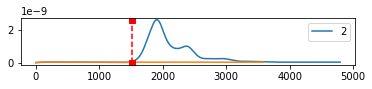

========================= 1310


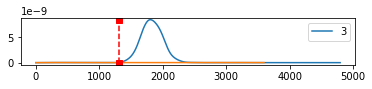

========================= 1311


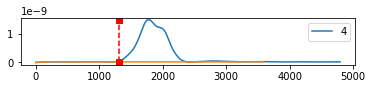

################################ TRIAL 38 ################################
========================= 1051


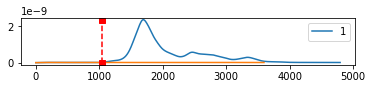

========================= 1195


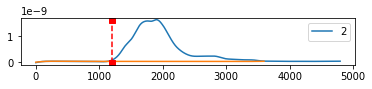

========================= 530


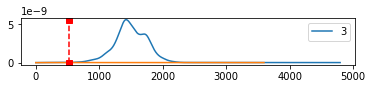

========================= 934


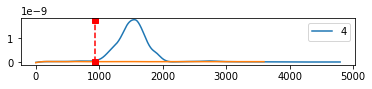

################################ TRIAL 39 ################################
========================= 1286


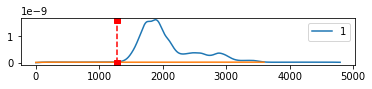

========================= 1323


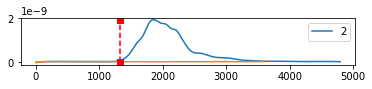

========================= 1142


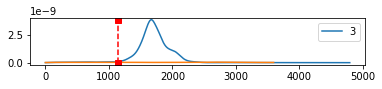

========================= 579


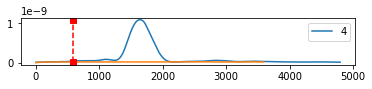

################################ TRIAL 40 ################################
========================= 1674


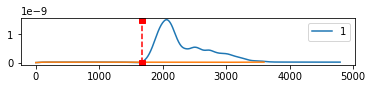

========================= 1679


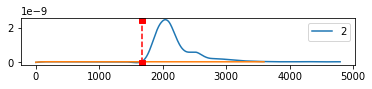

========================= 1445


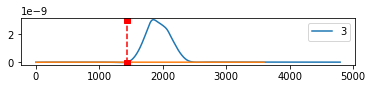

========================= 1472


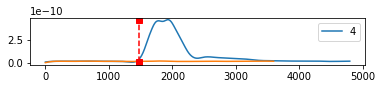

################################ TRIAL 41 ################################
========================= 1203


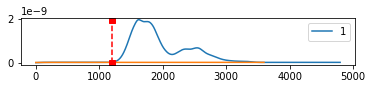

========================= 1146


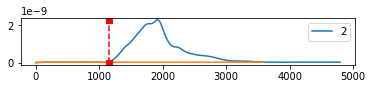

========================= 607


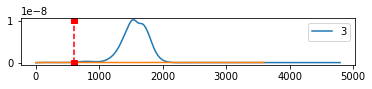

========================= 693


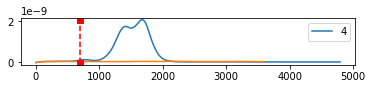

################################ TRIAL 42 ################################
========================= 1457


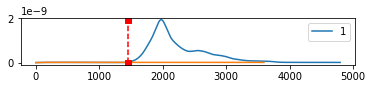

========================= 1449


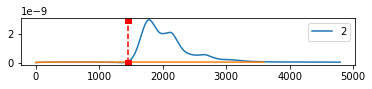

========================= 1307


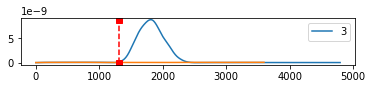

========================= 1347


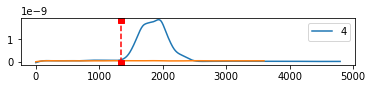

################################ TRIAL 43 ################################
========================= 1542


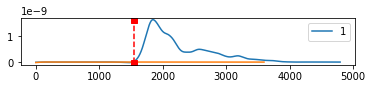

========================= 1428


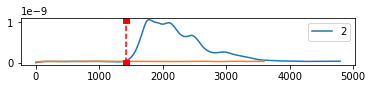

========================= 999


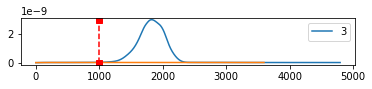

========================= 1346


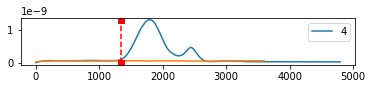

################################ TRIAL 44 ################################
========================= 1256


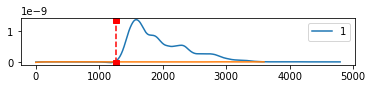

========================= 1218


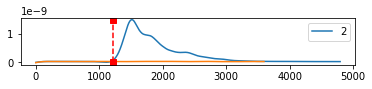

========================= 690


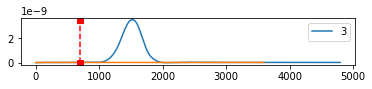

========================= 1023


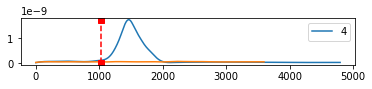

################################ TRIAL 45 ################################
========================= 1226


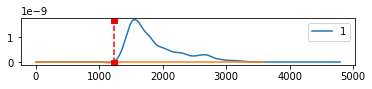

========================= 1182


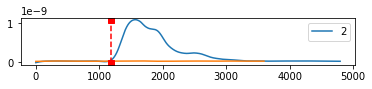

========================= 1056


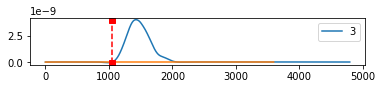

========================= 1079


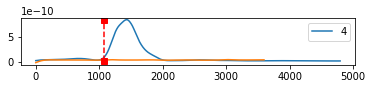

################################ TRIAL 46 ################################
========================= 1218


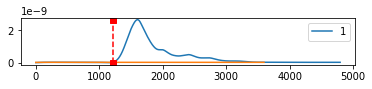

========================= 1125


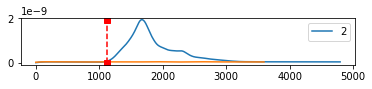

========================= 519


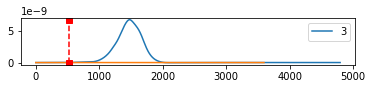

========================= 886


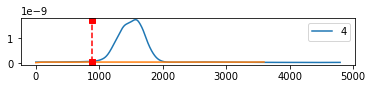

################################ TRIAL 47 ################################
========================= 1577


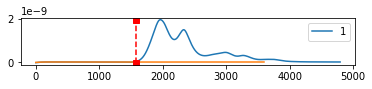

========================= 1503


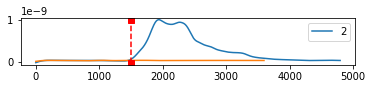

========================= 1092


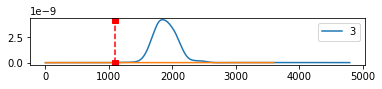

========================= 1535


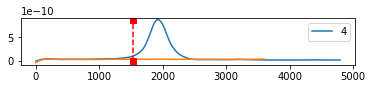

################################ TRIAL 48 ################################
========================= 1398


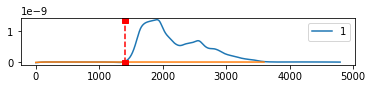

========================= 1365


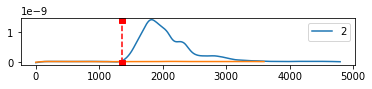

========================= 1083


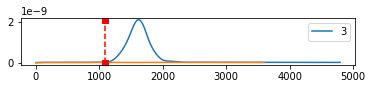

========================= 1173


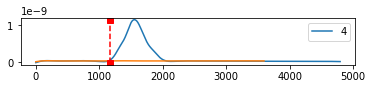

################################ TRIAL 49 ################################
========================= 1470


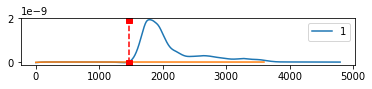

========================= 1418


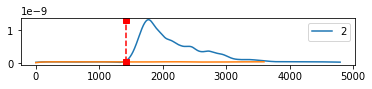

========================= 774


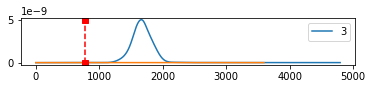

========================= 1251


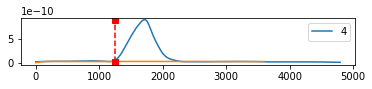

################################ TRIAL 50 ################################
========================= 1404


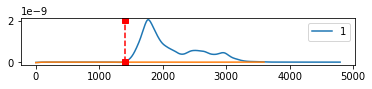

========================= 1353


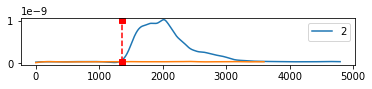

========================= 896


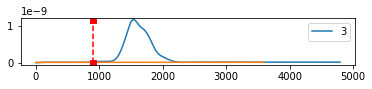

========================= 1319


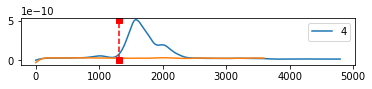

################################ TRIAL 51 ################################
========================= 1582


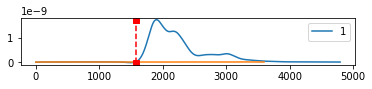

========================= 1541


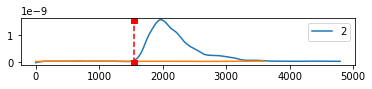

========================= 973


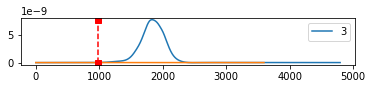

========================= 1324


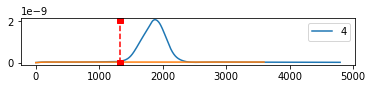

################################ TRIAL 52 ################################
========================= 1415


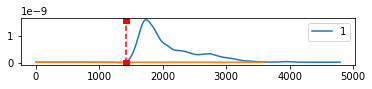

========================= 1376


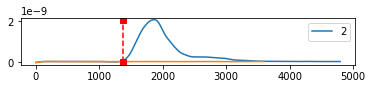

========================= 1237


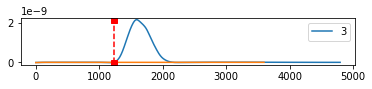

========================= 1166


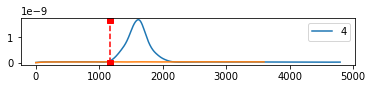

################################ TRIAL 53 ################################
========================= 1393


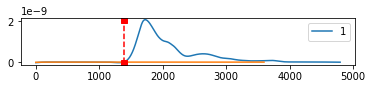

========================= 1367


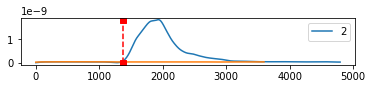

========================= 569


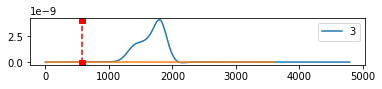

========================= 1213


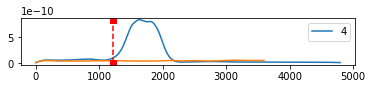

################################ TRIAL 54 ################################
========================= 1254


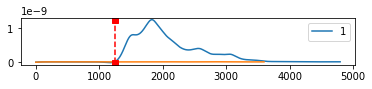

========================= 1297


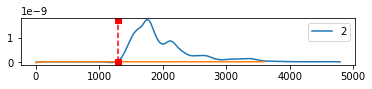

========================= 665


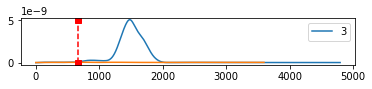

========================= 1200


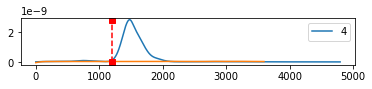

################################ TRIAL 55 ################################
========================= 1068


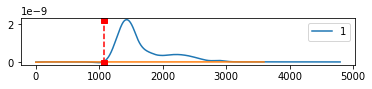

========================= 1023


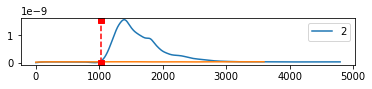

========================= 705


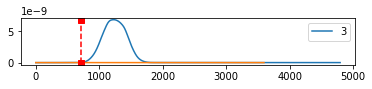

========================= 801


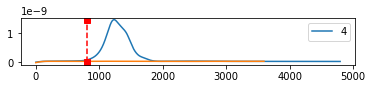

################################ TRIAL 56 ################################
========================= 1268


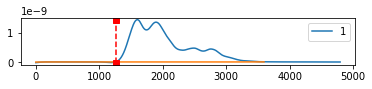

========================= 1166


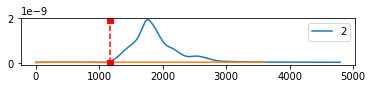

========================= 761


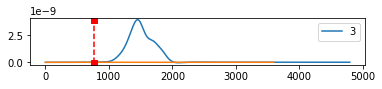

========================= 771


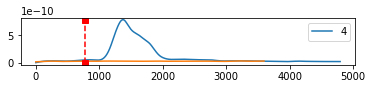

################################ TRIAL 57 ################################
========================= 1603


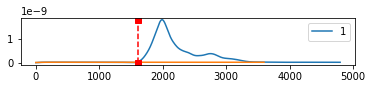

========================= 1586


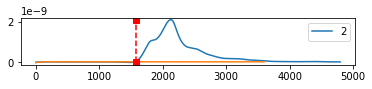

========================= 1103


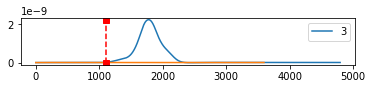

========================= 1499


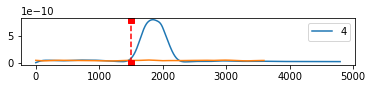

################################ TRIAL 58 ################################
========================= 1478


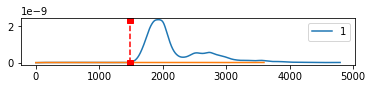

========================= 1378


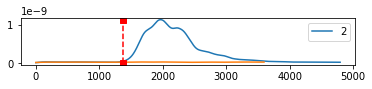

========================= 1186


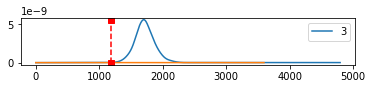

========================= 1300


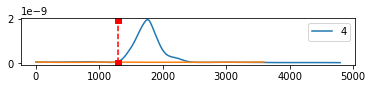

################################ TRIAL 59 ################################
========================= 1796


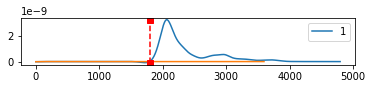

========================= 1756


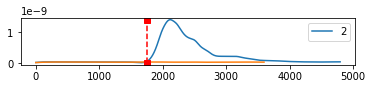

========================= 1452


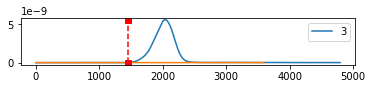

========================= 1497


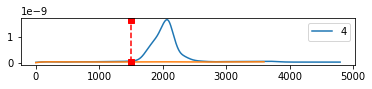

################################ TRIAL 60 ################################
========================= 1488


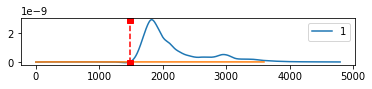

========================= 1450


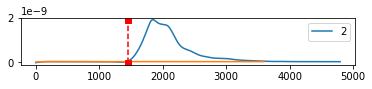

========================= 1298


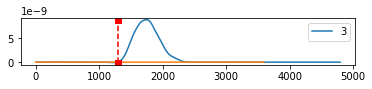

========================= 1356


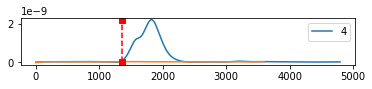

################################ TRIAL 61 ################################
========================= 1656


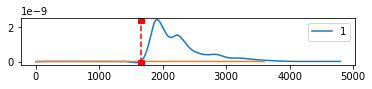

========================= 1609


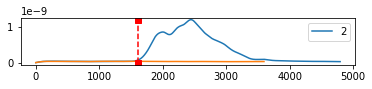

========================= 580


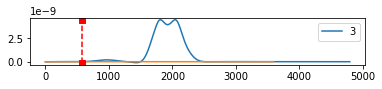

========================= 967


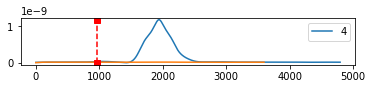

################################ TRIAL 62 ################################
========================= 1377


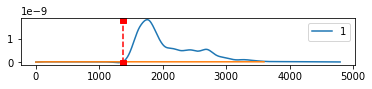

========================= 1361


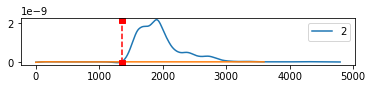

========================= 760


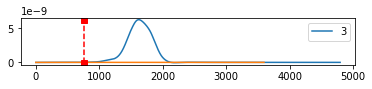

========================= 837


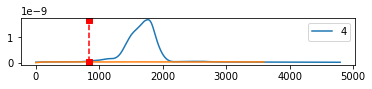

################################ TRIAL 63 ################################
========================= 1610


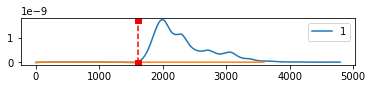

========================= 1575


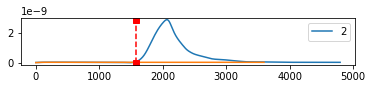

========================= 1220


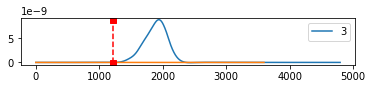

========================= 1154


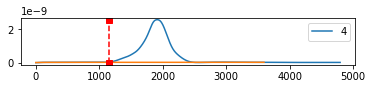

################################ TRIAL 64 ################################
========================= 1424


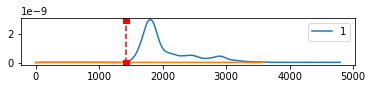

========================= 1396


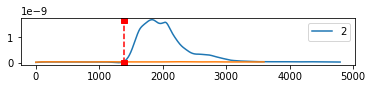

========================= 781


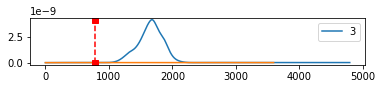

========================= 1077


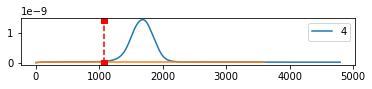

################################ TRIAL 65 ################################
========================= 1384


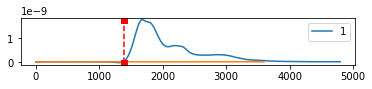

========================= 1402


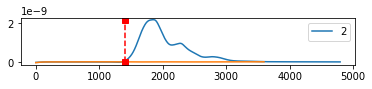

========================= 532


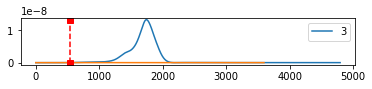

========================= 611


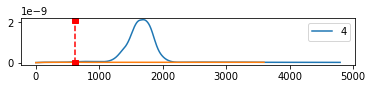

################################ TRIAL 66 ################################
========================= 1278


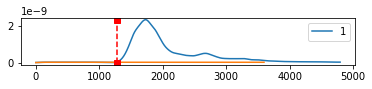

========================= 1256


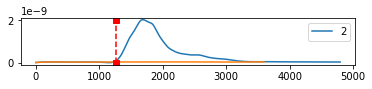

========================= 606


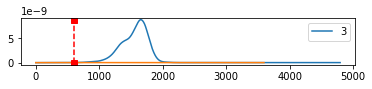

========================= 1067


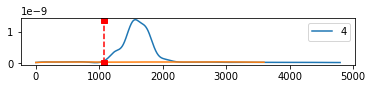

################################ TRIAL 67 ################################
========================= 1509


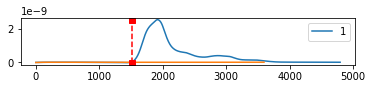

========================= 1435


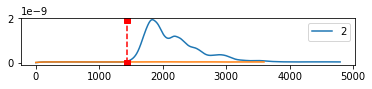

========================= 912


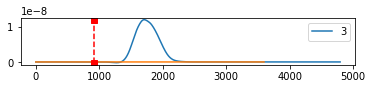

========================= 1356


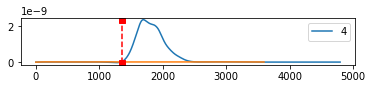

################################ TRIAL 68 ################################
========================= 1225


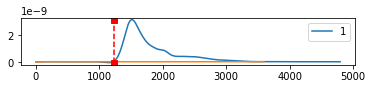

========================= 1169


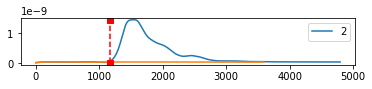

========================= 755


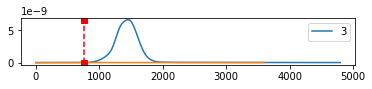

========================= 906


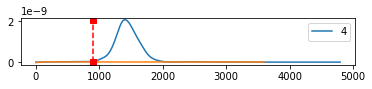

################################ TRIAL 69 ################################
========================= 1311


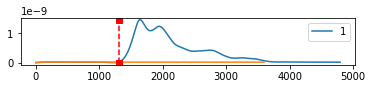

========================= 1318


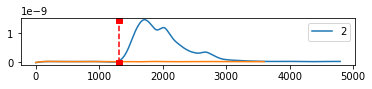

========================= 526


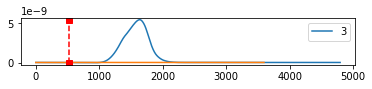

========================= 1069


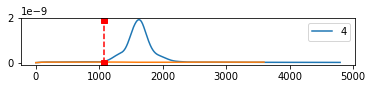

################################ TRIAL 70 ################################
========================= 1328


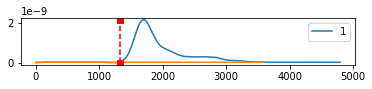

========================= 1303


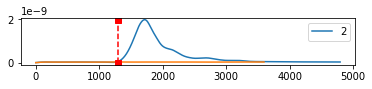

========================= 634


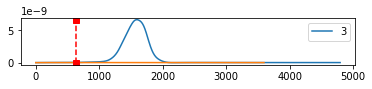

========================= 767


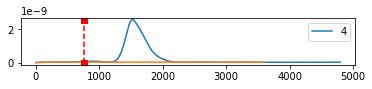

################################ TRIAL 71 ################################
========================= 1589


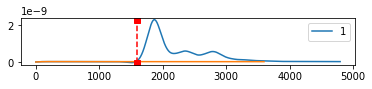

========================= 1587


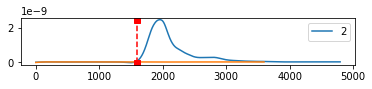

========================= 1317


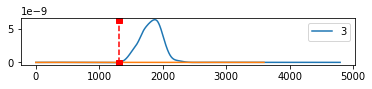

========================= 1373


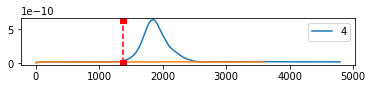

################################ TRIAL 72 ################################
========================= 1654


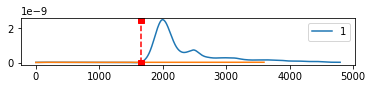

========================= 1654


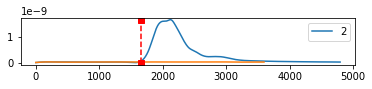

========================= 1116


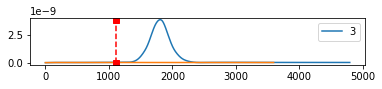

========================= 1476


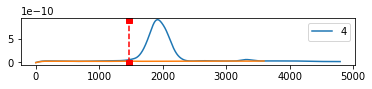

################################ TRIAL 73 ################################
========================= 1301


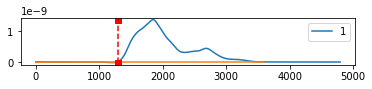

========================= 1308


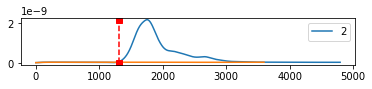

========================= 696


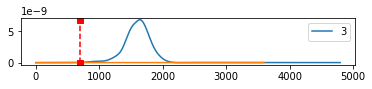

========================= 733


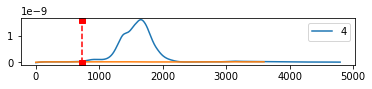

################################ TRIAL 74 ################################
========================= 1238


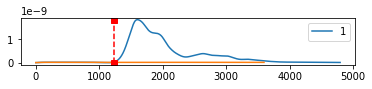

========================= 1231


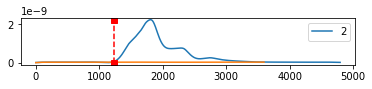

========================= 804


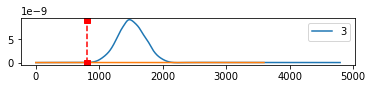

========================= 893


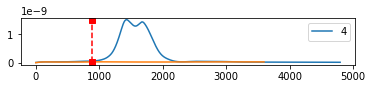

################################ TRIAL 75 ################################
========================= 1399


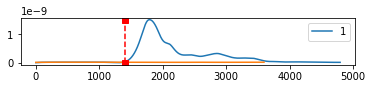

========================= 1415


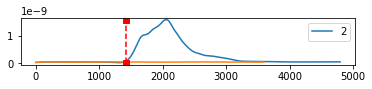

========================= 795


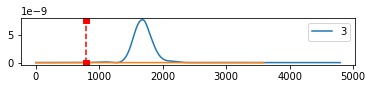

========================= 833


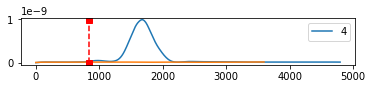

################################ TRIAL 76 ################################
========================= 1480


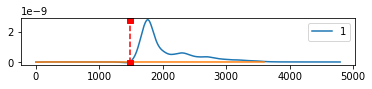

========================= 1360


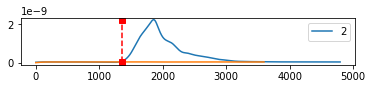

========================= 496


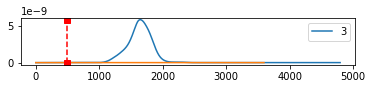

========================= 616


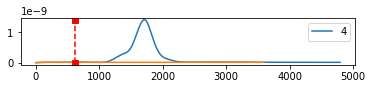

################################ TRIAL 77 ################################
========================= 1140


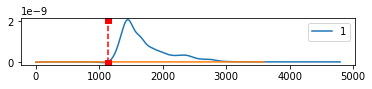

========================= 1148


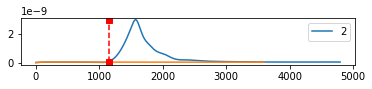

========================= 561


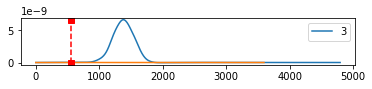

========================= 602


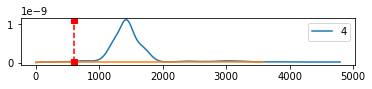

################################ TRIAL 78 ################################
========================= 1484


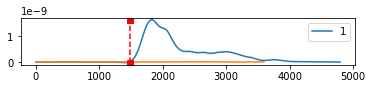

========================= 1509


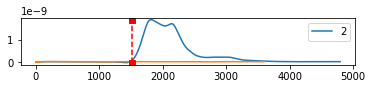

========================= 1039


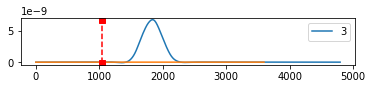

========================= 923


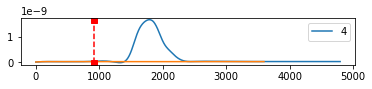

################################ TRIAL 79 ################################
========================= 1393


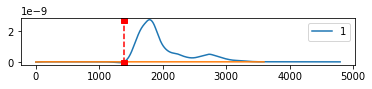

========================= 1405


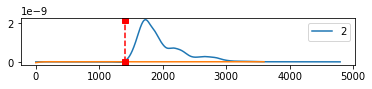

========================= 1175


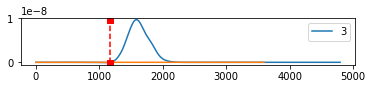

========================= 1211


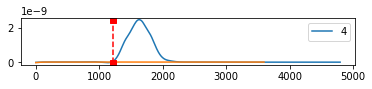

################################ TRIAL 80 ################################
========================= 1242


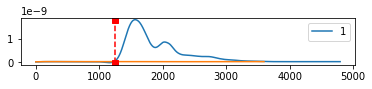

========================= 1251


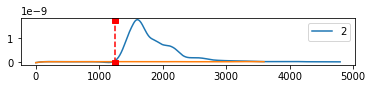

========================= 654


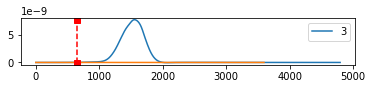

========================= 776


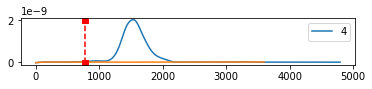

################################ TRIAL 81 ################################
========================= 1439


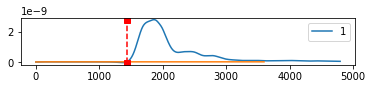

========================= 1460


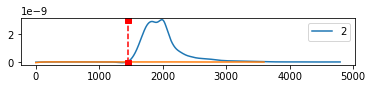

========================= 1202


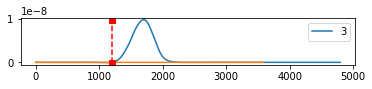

========================= 1199


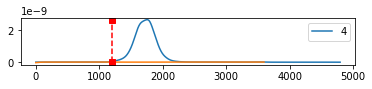

################################ TRIAL 82 ################################
========================= 1368


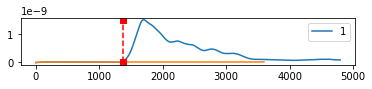

========================= 1326


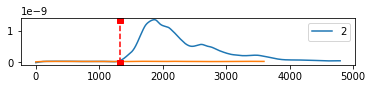

========================= 1154


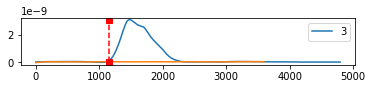

========================= 1176


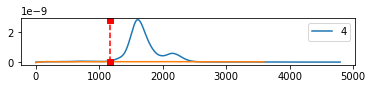

################################ TRIAL 83 ################################
========================= 1518


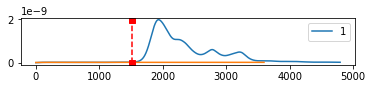

========================= 1571


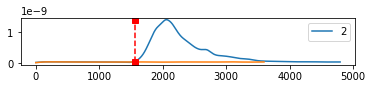

========================= 1236


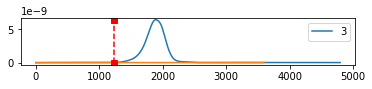

========================= 1466


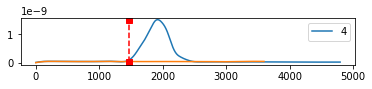

################################ TRIAL 84 ################################
========================= 1169


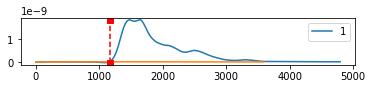

========================= 1144


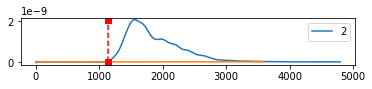

========================= 365


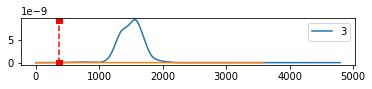

========================= 1071


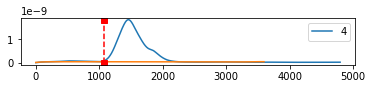

################################ TRIAL 85 ################################
========================= 1134


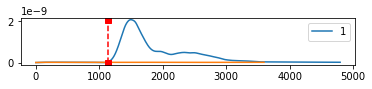

========================= 1152


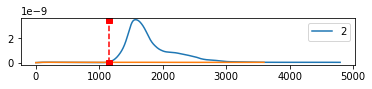

========================= 556


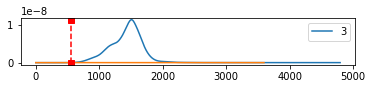

========================= 520


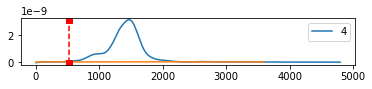

################################ TRIAL 86 ################################
========================= 1505


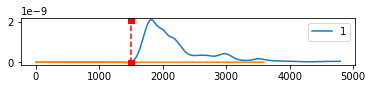

========================= 1457


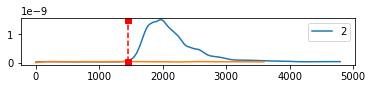

========================= 935


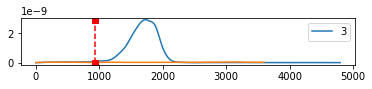

========================= 1178


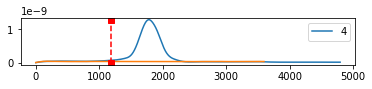

################################ TRIAL 87 ################################
========================= 1128


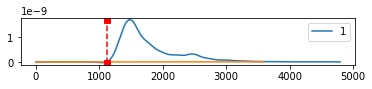

========================= 1165


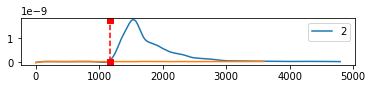

========================= 584


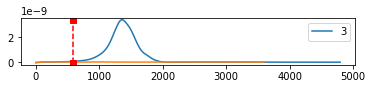

========================= 1055


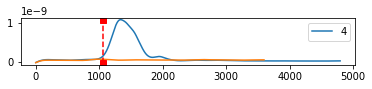

################################ TRIAL 88 ################################
========================= 1712


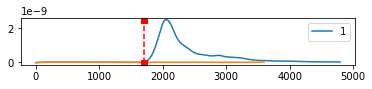

========================= 1647


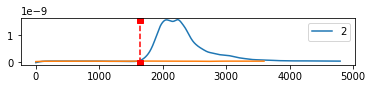

========================= 1124


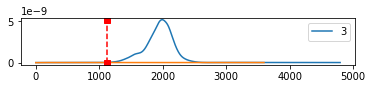

========================= 1316


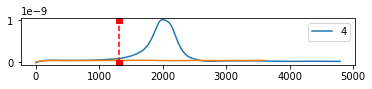

################################ TRIAL 89 ################################
========================= 1375


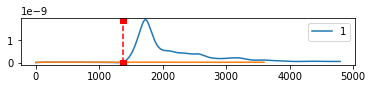

========================= 1351


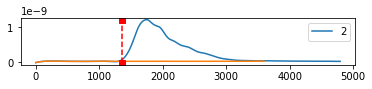

========================= 950


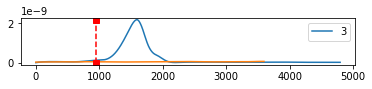

========================= 1309


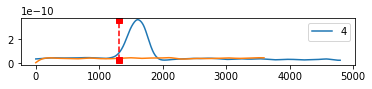

################################ TRIAL 90 ################################
========================= 1375


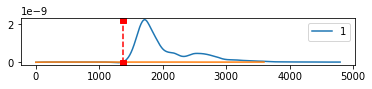

========================= 1382


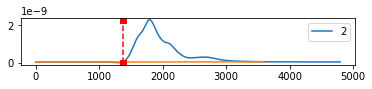

========================= 1085


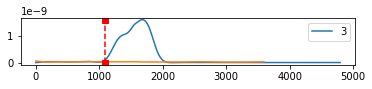

========================= 1371


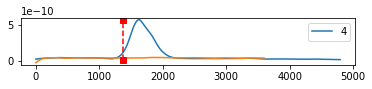

################################ TRIAL 91 ################################
========================= 1421


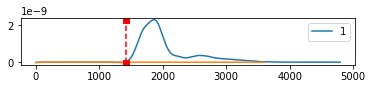

========================= 1412


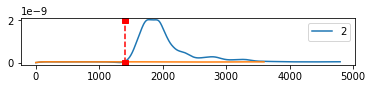

========================= 1017


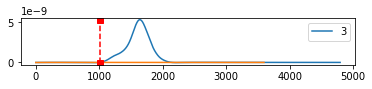

========================= 1301


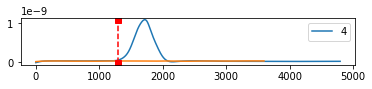

################################ TRIAL 92 ################################
========================= 1529


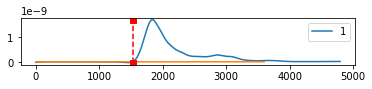

========================= 1498


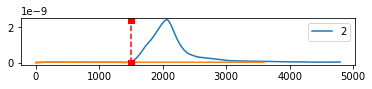

========================= 680


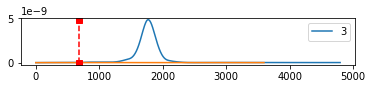

========================= 1307


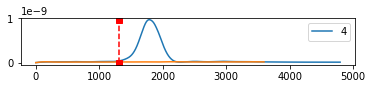

################################ TRIAL 93 ################################
========================= 1416


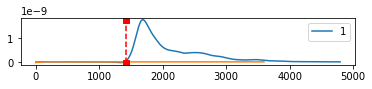

========================= 1368


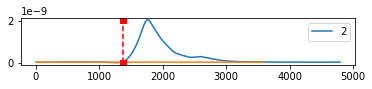

========================= 458


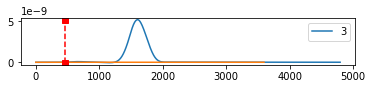

========================= 647


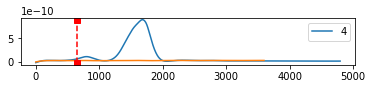

################################ TRIAL 94 ################################
========================= 1323


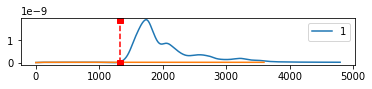

========================= 1279


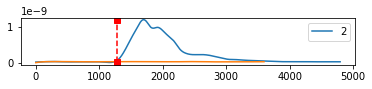

========================= 1040


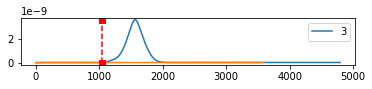

========================= 1169


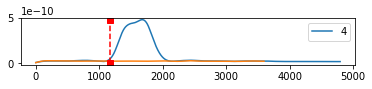

################################ TRIAL 95 ################################
========================= 1312


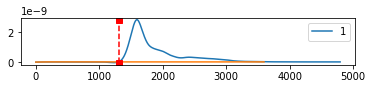

========================= 1238


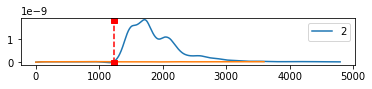

========================= 552


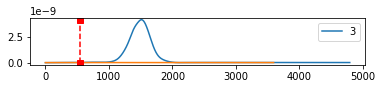

========================= 1050


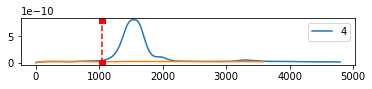

################################ TRIAL 96 ################################
========================= 1272


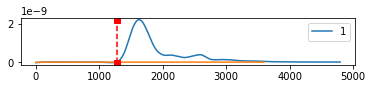

========================= 1173


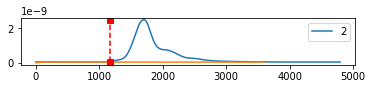

========================= 400


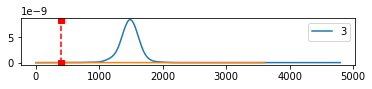

========================= 1131


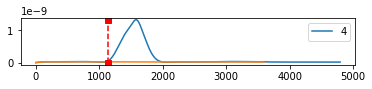

################################ TRIAL 97 ################################
========================= 1543


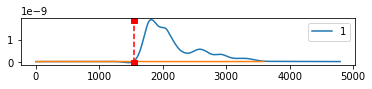

========================= 1580


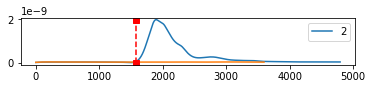

========================= 883


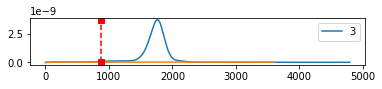

========================= 1426


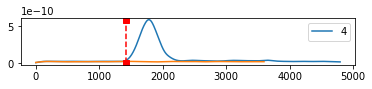

################################ TRIAL 98 ################################
========================= 1621


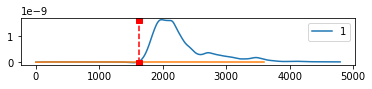

========================= 1620


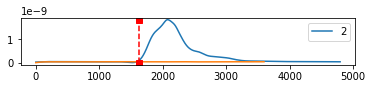

========================= 1272


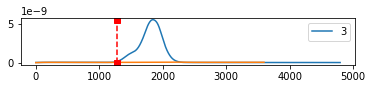

========================= 1228


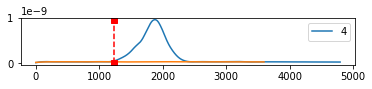

################################ TRIAL 99 ################################
========================= 1252


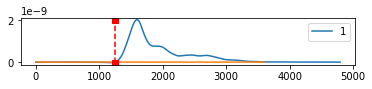

========================= 1272


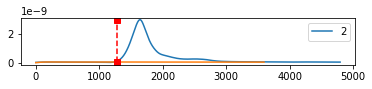

========================= 427


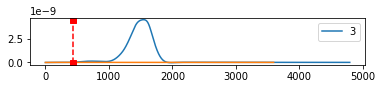

========================= 1175


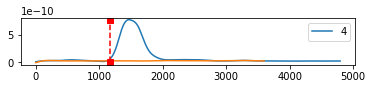

################################ TRIAL 100 ################################
========================= 1562


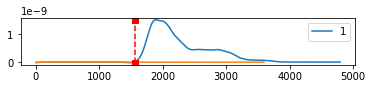

========================= 1553


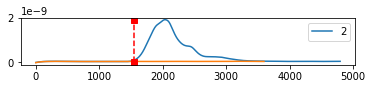

========================= 1298


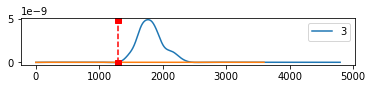

========================= 864


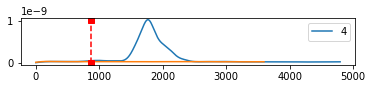

In [9]:
sit_onset = all_onset_point(sit_data_resample, sit_fixation_resample, 3, 1200)
stand_onset = all_onset_point(stand_data_resample, stand_fixation_resample, 3, 1200)

# SAVE TO ARRAY

In [10]:
np.save('stand_onset.npy', stand_onset)
np.save('sit_onset.npy', sit_onset)

[[ 604.  839.  723.  838.]
 [ 748.  919.  740.  995.]
 [ 968. 1127. 1169. 1268.]
 [ 739. 1083. 1240. 1531.]
 [1150. 1169. 1383. 1615.]
 [1030. 1151. 1275. 1345.]
 [ 865.  988. 1245. 1427.]
 [ 968. 1174. 1151. 1179.]
 [ 793.  873. 1179. 1222.]
 [1236. 1240. 1357. 1362.]
 [1085. 1208. 1310. 1303.]
 [1115. 1151. 1184. 1489.]
 [ 904.  800. 1128. 1234.]
 [1036.  991. 1354. 1399.]
 [1003.  672. 1352.  634.]
 [1224. 1060. 1365. 1844.]
 [1089. 1088. 1215. 1218.]
 [ 893. 1020. 1287. 1926.]
 [1349. 1446. 1639. 1732.]
 [ 936. 1109. 1485. 1545.]
 [1027. 1045. 1337. 1343.]
 [1131. 1166. 1449. 1482.]
 [1158. 1186. 1567. 1669.]
 [1039. 1137. 1084. 1096.]
 [1278. 1352. 1491. 1877.]
 [1130. 1164. 1428. 1787.]
 [1159. 1266. 1702. 1717.]
 [1450. 1430. 1596. 2094.]
 [1007. 1069. 1278. 1674.]
 [1052. 1022. 1337. 1344.]
 [1176. 1152. 1497. 1709.]
 [ 913. 1084. 1257. 1503.]
 [1372. 1510. 1674. 1914.]
 [ 775. 1016. 1386. 1548.]
 [1011.  980. 1228. 1394.]
 [1064. 1092. 1551. 1654.]
 [1271. 1437. 1439. 1913.]
 